In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_style('whitegrid')

In [2]:
from load_data import load_ticker

stats = load_ticker('SBER')
stats.keys()

dict_keys(['info', 'marketdata', 'obstats', 'tradestats', 'orderstats'])

# Add time column and check that data is sorted by time

In [3]:
def preprocess_stats(stats: dict[str, pd.DataFrame]) -> dict[str, pd.DataFrame]:
    if len(stats) == 3:
        return stats
    assert len(stats) == 5
    result = {}
    for name in ['tradestats', 'obstats', 'orderstats']:
        df = stats[name].copy()
        assert (df.index == range(len(df))).all()
        # Add time
        df['time'] = pd.to_datetime(df['tradedate'].astype(str) + ' ' + df['tradetime'].astype(str))
        df = df.set_index('time')
        assert df.index.is_monotonic_increasing
        # Check ticker
        ticker = df['ticker'].iloc[0]
        assert (df['ticker'] == ticker).all()
        # Drop redundant time columns and ticker column
        df = df.drop(columns=['tradedate', 'tradetime', 'ticker', 'systime'])
        # Store result
        result[name] = df
        # Do time and index checks
    return result


stats = preprocess_stats(stats)
stats.keys()

dict_keys(['tradestats', 'obstats', 'orderstats'])

# Drop days with not enough observations

In [4]:
TIME_RANGE = []
for h in range(10, 19):
    for m in range(0, 60, 5):
        if h == 10 and m == 0:
            continue
        if h == 18 and m > 40:
            break
        TIME_RANGE.append(datetime.time(h, m))

In [5]:
def drop_nans(stats: dict[str, pd.DataFrame]):
    missing_dates = set()
    print('Drop days:')
    for name, df in stats.items():
        # Check time correctness
        assert np.isin(df.index.time, TIME_RANGE).all()
        # Find dates with missing observations
        new_missing_dates = []
        for date, ind in df.groupby(df.index.date).groups.items():
            if len(ind) != len(TIME_RANGE):
                new_missing_dates.append(date)
        print(f'{name}: {new_missing_dates}')
        missing_dates.update(new_missing_dates)
    missing_dates = sorted(missing_dates)
    print('Drop (union of dropped days):', missing_dates)

    all_dates = set()
    common_dates = set(next(iter(stats.values())).index.date)
    for df in stats.values():
        all_dates.update(df.index.date)
        common_dates = common_dates & set(df.index.date)
    not_common_dates = sorted(all_dates - common_dates - set(missing_dates))
    print(f'Drop not common dates: {not_common_dates}')
    missing_dates = sorted(set(missing_dates) | set(not_common_dates))

    # Drop dates with missing observations
    result = {}
    for name, df in stats.items():
        df = df[~np.isin(df.index.date, missing_dates)]
        result[name] = df
    time = next(iter(result.values())).index
    for df in result.values():
        assert (df.index == time).all()
    return result


stats = drop_nans(stats)

Drop days:
tradestats: [datetime.date(2020, 5, 8), datetime.date(2021, 11, 26), datetime.date(2022, 2, 24), datetime.date(2022, 2, 25), datetime.date(2022, 3, 24), datetime.date(2022, 3, 25), datetime.date(2022, 3, 28), datetime.date(2022, 3, 29), datetime.date(2022, 3, 30), datetime.date(2023, 11, 23), datetime.date(2023, 11, 27), datetime.date(2023, 11, 28)]
obstats: [datetime.date(2021, 11, 30), datetime.date(2022, 12, 7)]
orderstats: [datetime.date(2020, 5, 8), datetime.date(2021, 11, 26), datetime.date(2022, 3, 24), datetime.date(2022, 3, 25), datetime.date(2022, 3, 28), datetime.date(2022, 3, 29), datetime.date(2022, 3, 30)]
Drop (union of dropped days): [datetime.date(2020, 5, 8), datetime.date(2021, 11, 26), datetime.date(2021, 11, 30), datetime.date(2022, 2, 24), datetime.date(2022, 2, 25), datetime.date(2022, 3, 24), datetime.date(2022, 3, 25), datetime.date(2022, 3, 28), datetime.date(2022, 3, 29), datetime.date(2022, 3, 30), datetime.date(2022, 12, 7), datetime.date(2023, 1

In [6]:
print('Columns:')
for name in ['tradestats', 'obstats', 'orderstats']:
    print(f'{name}:')
    print(stats[name].columns.tolist())

Columns:
tradestats:
['pr_open', 'pr_high', 'pr_low', 'pr_close', 'pr_std', 'vol', 'val', 'trades', 'pr_vwap', 'pr_change', 'trades_b', 'trades_s', 'val_b', 'val_s', 'vol_b', 'vol_s', 'disb', 'pr_vwap_b', 'pr_vwap_s']
obstats:
['spread_bbo', 'spread_lv10', 'spread_1mio', 'levels_b', 'levels_s', 'vol_b', 'vol_s', 'val_b', 'val_s', 'imbalance_vol_bbo', 'imbalance_val_bbo', 'imbalance_vol', 'imbalance_val', 'vwap_b', 'vwap_s', 'vwap_b_1mio', 'vwap_s_1mio']
orderstats:
['put_orders_b', 'put_orders_s', 'put_val_b', 'put_val_s', 'put_vol_b', 'put_vol_s', 'put_vwap_b', 'put_vwap_s', 'put_vol', 'put_val', 'put_orders', 'cancel_orders_b', 'cancel_orders_s', 'cancel_val_b', 'cancel_val_s', 'cancel_vol_b', 'cancel_vol_s', 'cancel_vwap_b', 'cancel_vwap_s', 'cancel_vol', 'cancel_val', 'cancel_orders']


# Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

all_ind = stats['tradestats'].index
train_dates, test_dates = train_test_split(sorted(set(all_ind.date)), shuffle=False, train_size=0.7)
train_ind = all_ind[np.isin(all_ind.date, train_dates)]
test_ind = all_ind[np.isin(all_ind.date, test_dates)]
assert train_ind.max() < test_ind.min()
assert train_ind.is_monotonic_increasing and test_ind.is_monotonic_increasing

print(f'Train: {train_ind[0].date()} - {train_ind[-1].date()}')
print(f'Test: {test_ind[0].date()} - {test_ind[-1].date()}')

Train: 2020-01-03 - 2021-12-24
Test: 2021-12-27 - 2022-12-06


# Investigate tradestats

In [8]:
df = stats['tradestats']

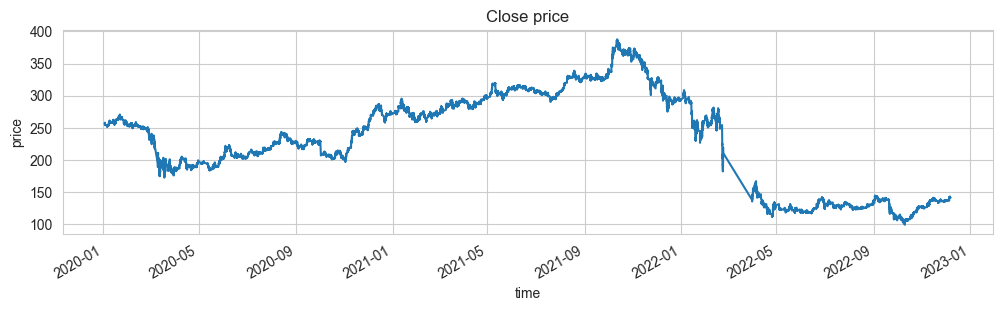

In [9]:
plt.figure(figsize=(12, 3))
df['pr_close'].plot()
plt.title('Close price')
plt.ylabel('price')
plt.gcf().autofmt_xdate()
plt.show()

In [10]:
from matplotlib.dates import DateFormatter


def time_to_date(time):
    return [datetime.datetime.combine(datetime.date.today(), t) for t in time]


def format_time():
    dfmt = DateFormatter("%H:%M")  # proper formatting Year-month-day
    plt.gca().xaxis.set_major_formatter(dfmt)

In [300]:
FIG_SIZE = (14, 3)


def moving_average(data, window_size):
    # Calculate the weights for the moving average
    weights = np.ones(window_size) / window_size
    # Pad the array at both ends to handle boundary values
    padded_data = np.pad(data, (window_size // 2, window_size // 2), mode='edge')
    return np.convolve(padded_data, weights, mode='valid')


def normalize_by_date(features: pd.DataFrame, n_window_days: int, use_mean: bool = True, plot: bool = False, title: str = '') -> pd.DataFrame:
    features = features.ffill()
    rolling_std = features.rolling(window=n_window_days * len(TIME_RANGE)).std()
    if use_mean:
        # Remove mean
        rolling_mean = features.rolling(window=n_window_days * len(TIME_RANGE)).mean()
        features = features - rolling_mean
    # Remove std
    new_features = features / rolling_std
    if plot:
        plot_features_by_date(features, title)
        plot_features_by_date(new_features, f'normalized {title}')
    return new_features


def plot_features_by_date(features: pd.DataFrame, title):
    plt.figure(figsize=FIG_SIZE)
    plt.title(f'Mean value of {title} by day')
    for col in features.columns:
        plt.plot(features[col].abs().groupby(df.index.date).mean(), label=col, alpha=0.5)
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()


def normalize_by_day_time(features: pd.DataFrame, smooth_window_size: int, use_mean: bool = True, plot: bool = False, title: str = '') -> pd.DataFrame:
    """
    Normalize features by time of the day with std smoothing
    """
    assert smooth_window_size % 2 == 1
    mean_by_day_time_smooth = {}
    mean_by_day_time = {}
    std_by_day_time_smooth = {}
    std_by_day_time = {}
    new_features = {}
    for col in features.columns:
        features_col = features[col]
        # Compute mean and std by day time
        group_obj = features_col[train_ind].groupby(train_ind.time)
        std_by_day_time[col] = group_obj.std()
        mean_by_day_time[col] = group_obj.mean()
        # Smooth mean and std
        std_by_day_time_smooth[col] = moving_average(std_by_day_time[col], window_size=smooth_window_size)
        mean_by_day_time_smooth[col] = moving_average(mean_by_day_time[col], window_size=smooth_window_size)
        # Do index check
        n_days = len(features_col) // len(TIME_RANGE)
        assert (features_col.index.time == np.tile(TIME_RANGE, n_days)).all()
        if use_mean:
            features_col = features_col - np.tile(mean_by_day_time_smooth[col], n_days)
        new_features[col] = features_col / np.tile(std_by_day_time_smooth[col], n_days)
    new_features = pd.DataFrame(new_features)
    if plot:
        plot_features_mean_std_smoothed_by_day_time(std_by_day_time, std_by_day_time_smooth, mean_by_day_time, mean_by_day_time_smooth, title=title)
        plot_features_mean_std_by_day_time(new_features, title=title)
    return new_features


def plot_features_mean_std_smoothed_by_day_time(std_by_day_time, std_by_day_time_smooth, mean_by_day_time, mean_by_day_time_smooth, title: str):
    labels = [('Standard deviation', 'std')]
    results = [(std_by_day_time, std_by_day_time_smooth)]
    if mean_by_day_time:
        labels.append(('Mean', 'mean'))
        results.append((mean_by_day_time, mean_by_day_time_smooth))

    for (y_label, title_label), (by_day_time, by_day_time_smooth) in zip(labels, results):
        plt.figure(figsize=FIG_SIZE)
        for i, col in enumerate(by_day_time.keys()):
            plt.plot(time_to_date(TIME_RANGE), by_day_time[col], label=col, color=f'C{i}')
            plt.plot(time_to_date(TIME_RANGE), by_day_time_smooth[col], label=f'{col} smoothed', linestyle='--', color=f'C{i}')
            format_time()
        plt.legend()
        plt.title(f'{title_label}({title})')
        plt.ylabel(y_label)
        plt.xlabel('Time')
        plt.show()


def plot_features_mean_std_by_day_time(features: pd.DataFrame, title: str):
    labels = ['Standard deviation', 'Mean']
    functions = ['std', 'mean']

    for label, function in zip(labels, functions):
        plt.figure(figsize=FIG_SIZE)
        for col in features.columns:
            group_obj = features.loc[test_ind, col].groupby(test_ind.time)
            plt.plot(time_to_date(TIME_RANGE), getattr(group_obj, function)(), label=col.removeprefix('pr_'))
            format_time()
        plt.legend()
        plt.title(f'Normalized {function}({title}) on Test')
        plt.ylabel(label)
        plt.xlabel('Time')
        plt.show()

In [12]:
TIME_SMOOTH_WINDOW_SIZE = 7
DAYS_WINDOW_SIZE = 5


def plot_features(df: pd.DataFrame, cols: list[str] = None, use_mean: bool = True, title: str = ''):
    if cols is None:
        cols = df.columns
    if not title:
        title = cols[0]
    norm_by_date = normalize_by_date(df[cols], n_window_days=DAYS_WINDOW_SIZE, use_mean=use_mean, plot=True, title=title)
    normalize_by_day_time(norm_by_date, smooth_window_size=TIME_SMOOTH_WINDOW_SIZE, use_mean=use_mean, plot=True, title=title)

In [13]:
OHL_COLS = ['pr_open', 'pr_high', 'pr_low']
OHLC_COLS = ['pr_open', 'pr_high', 'pr_low', 'pr_close']

VWAP_COLS = ['pr_vwap', 'pr_vwap_b', 'pr_vwap_s']
VWAPC_COLS = ['pr_vwap', 'pr_vwap_b', 'pr_vwap_s', 'pr_close']

## OHLC

In [14]:
def transform_ohlc(features: pd.DataFrame):
    assert (features.columns == OHLC_COLS).all()
    new_features = {}
    for col in OHL_COLS:
        new_features[f"log({col.removeprefix('pr_')}) - log(close)"] = np.log(features[col]) - np.log(features['pr_close'])
    return pd.DataFrame(new_features)

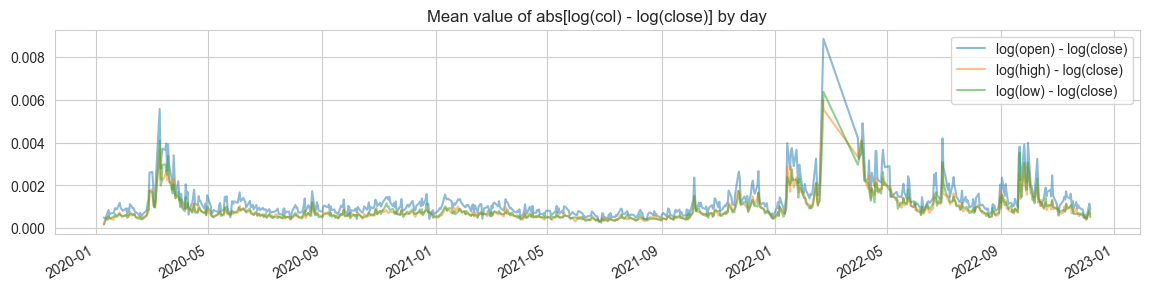

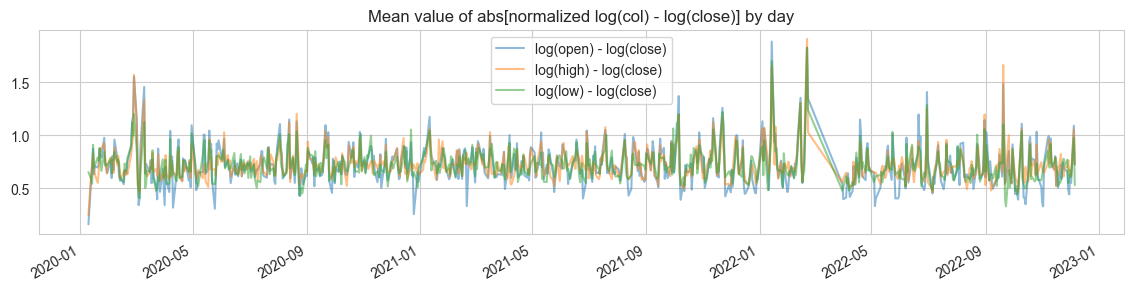

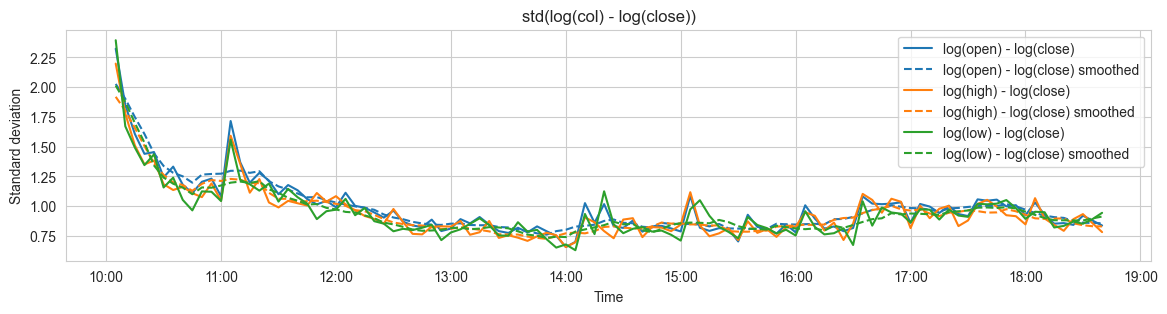

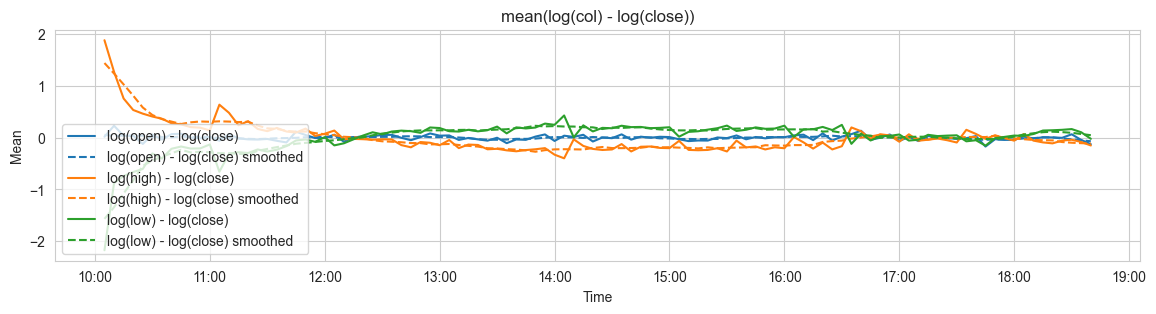

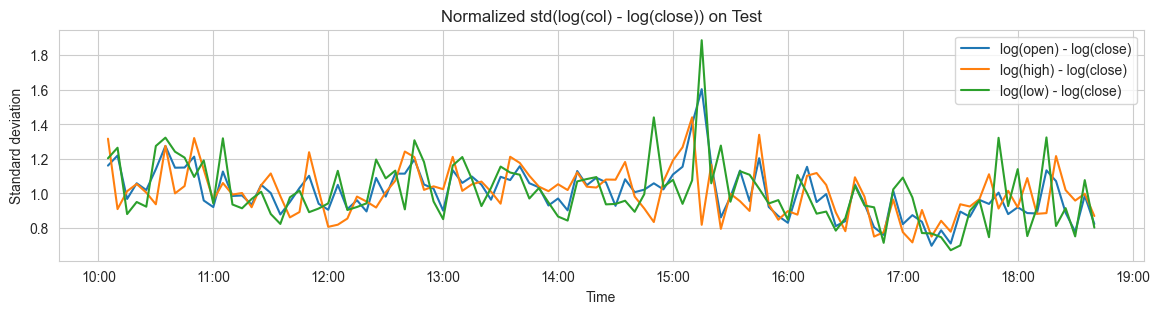

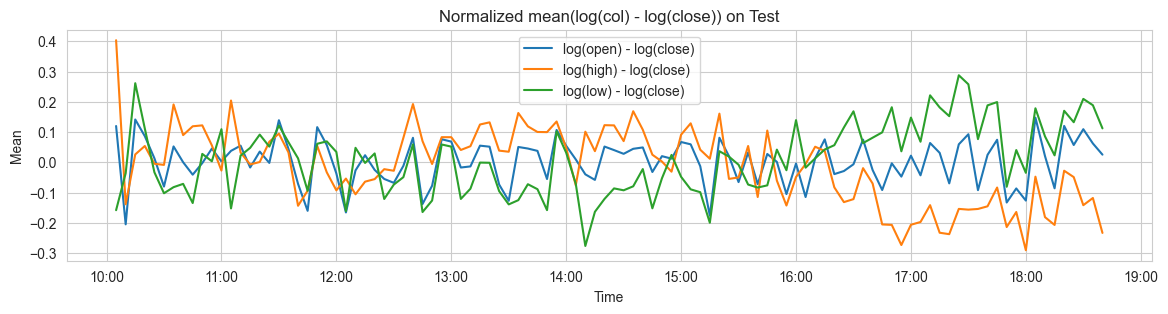

In [15]:
plot_features(transform_ohlc(df[OHLC_COLS]), title='log(col) - log(close)')

## pr_std

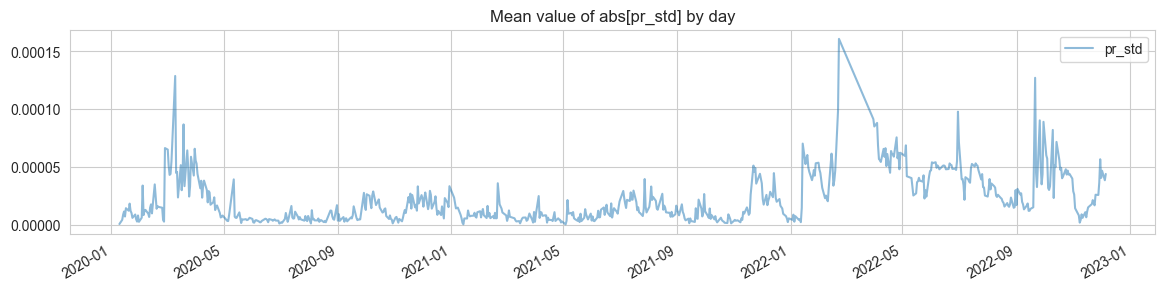

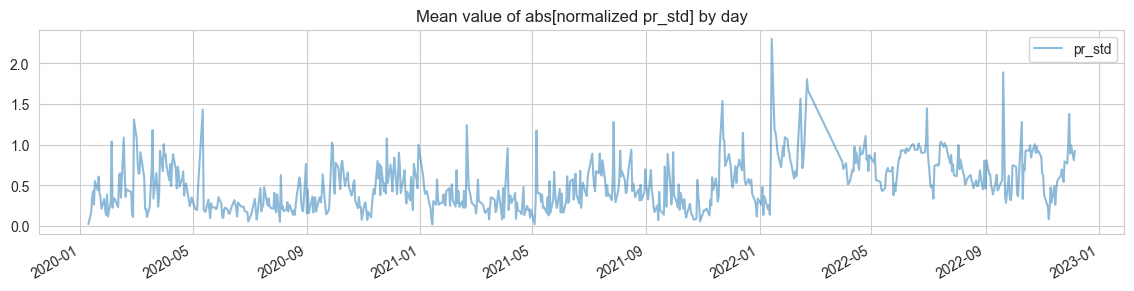

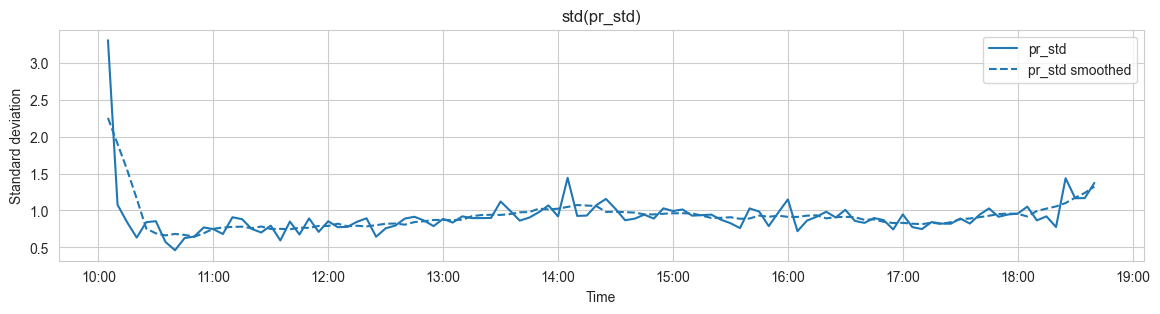

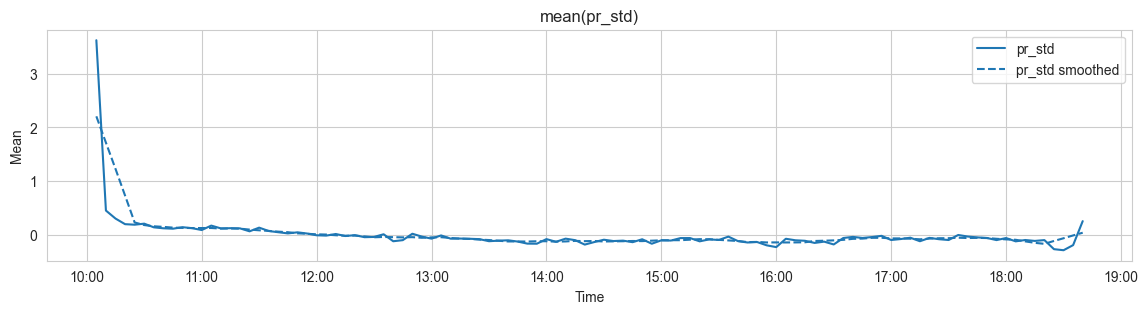

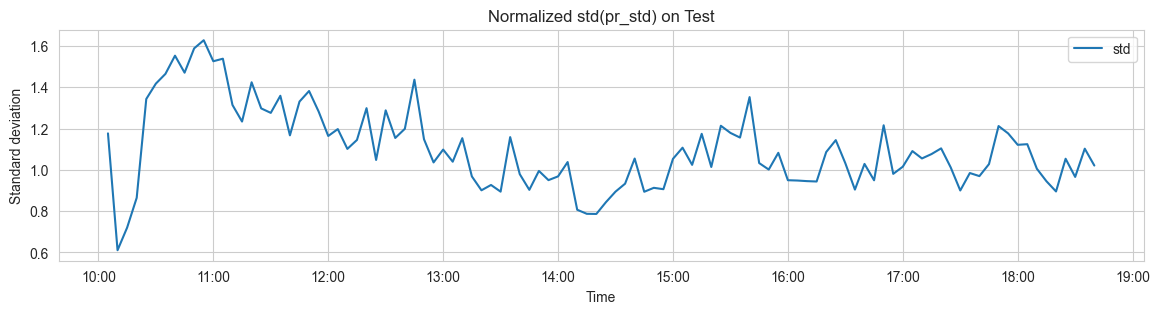

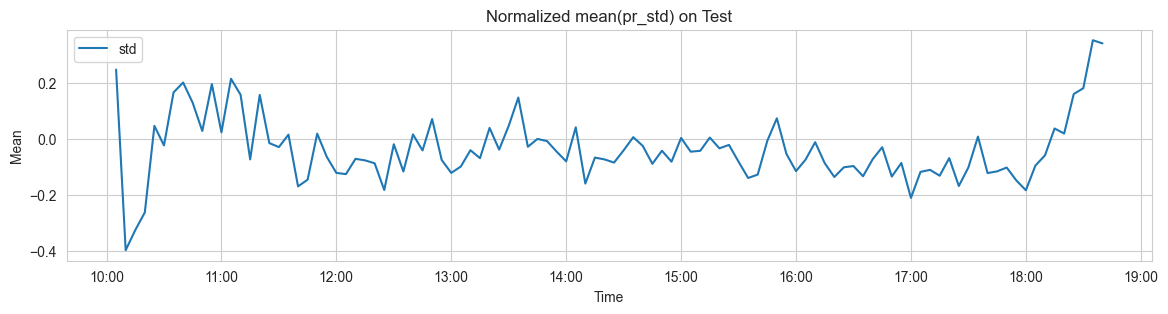

In [16]:
plot_features(df, cols=['pr_std'])

## vol, val

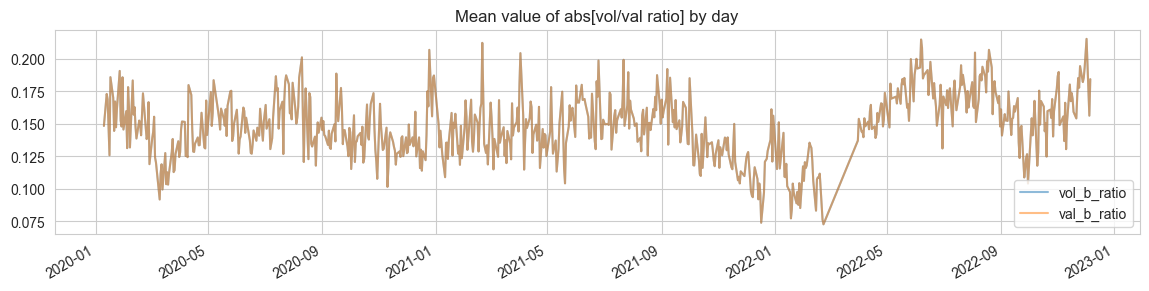

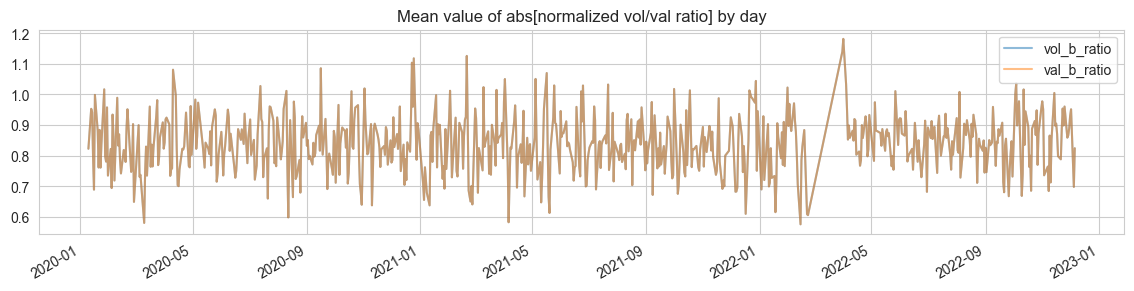

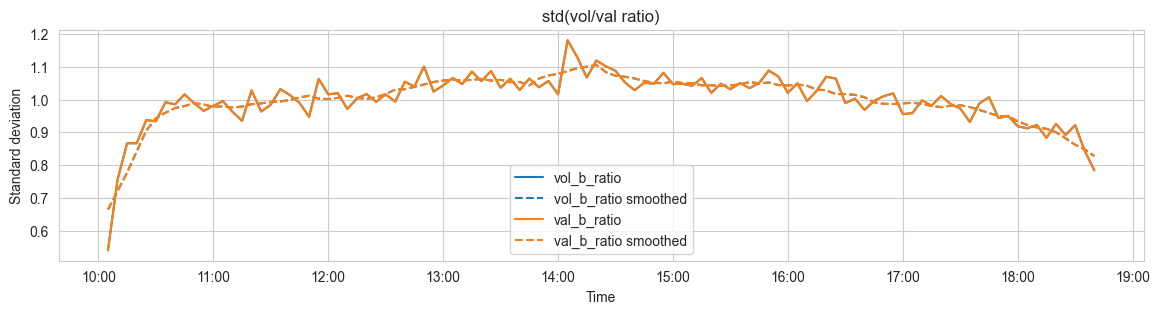

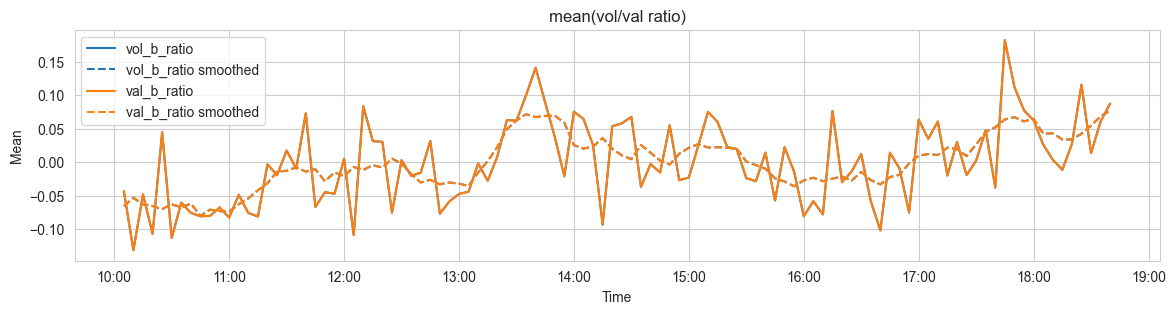

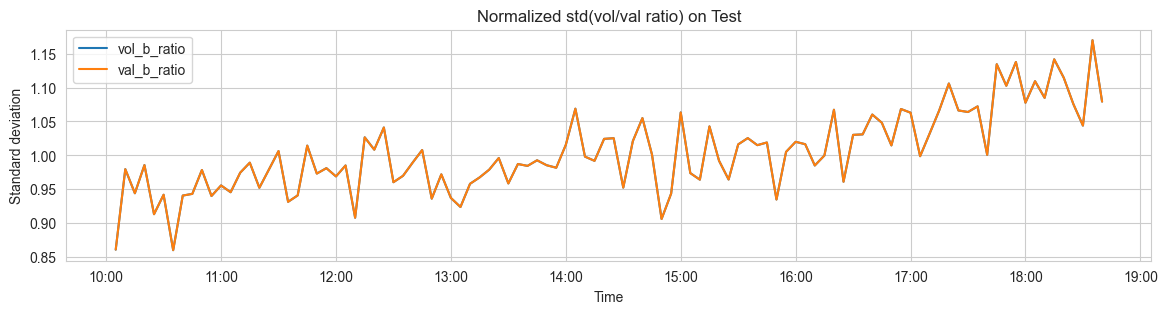

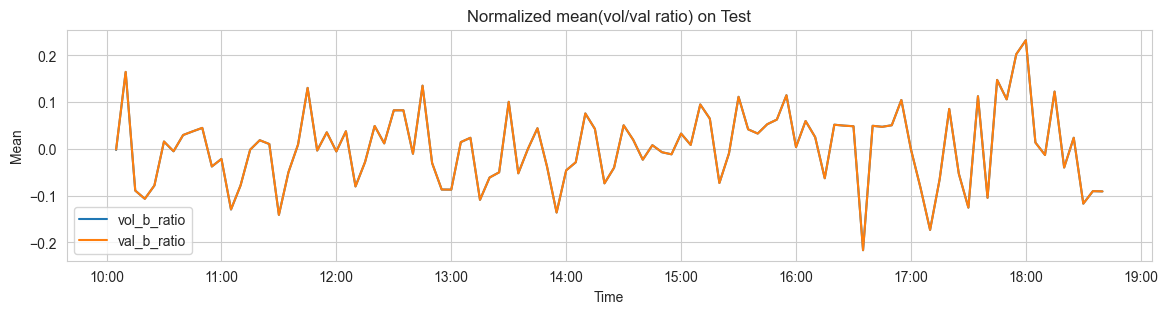

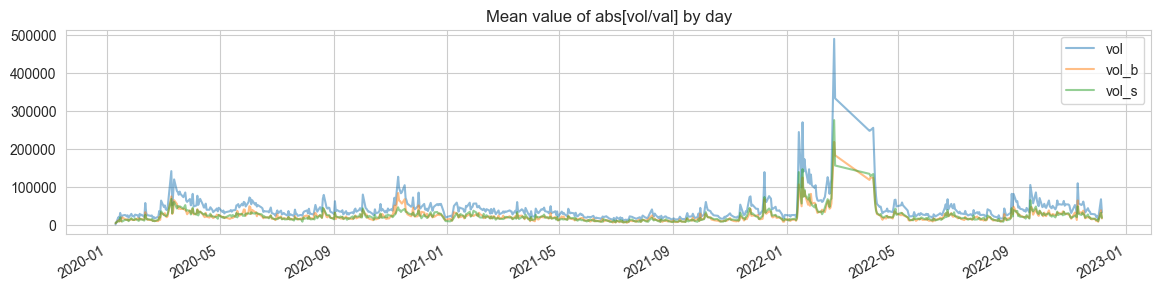

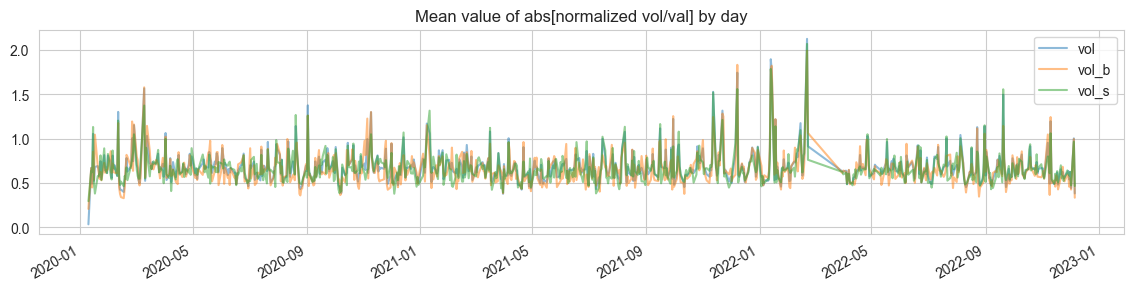

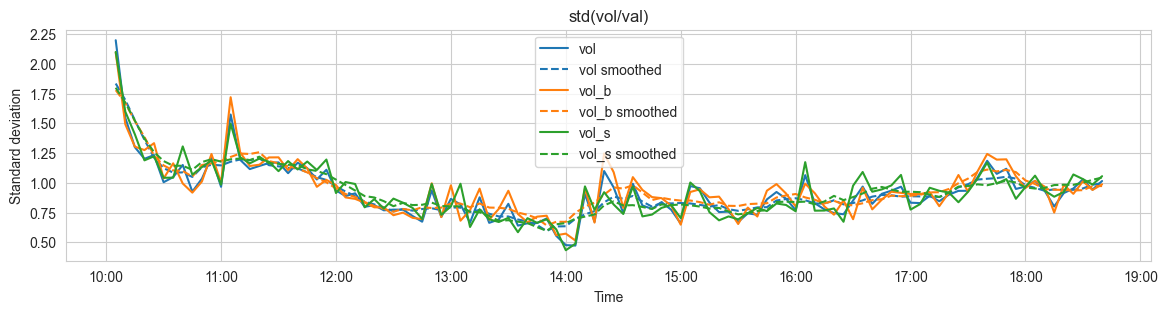

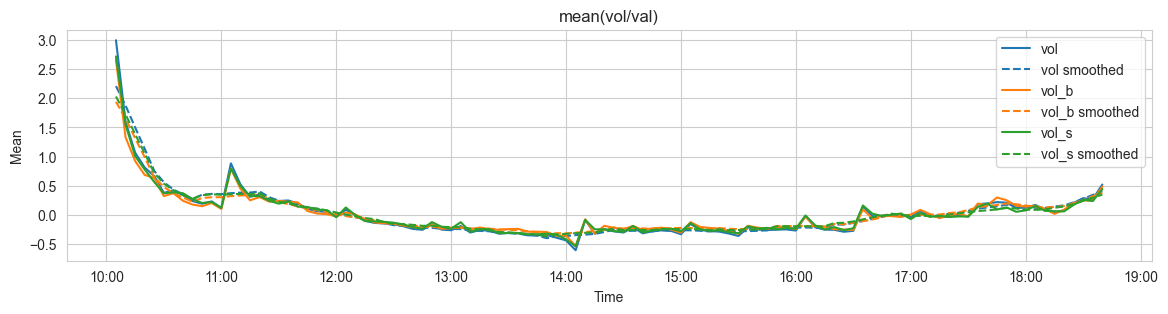

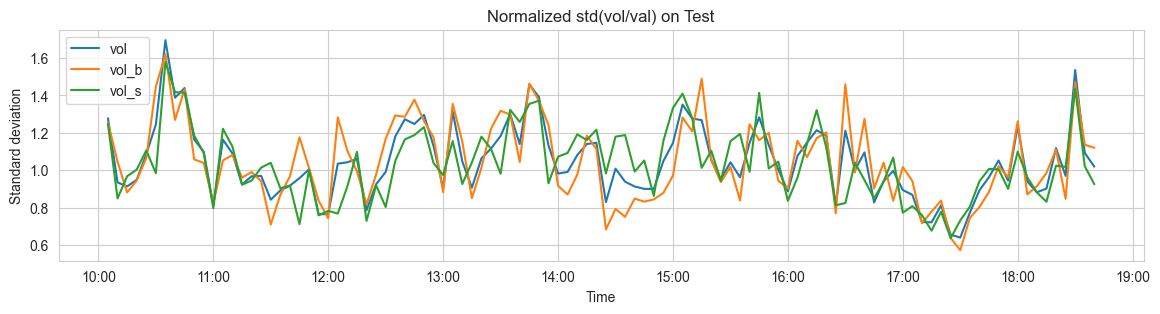

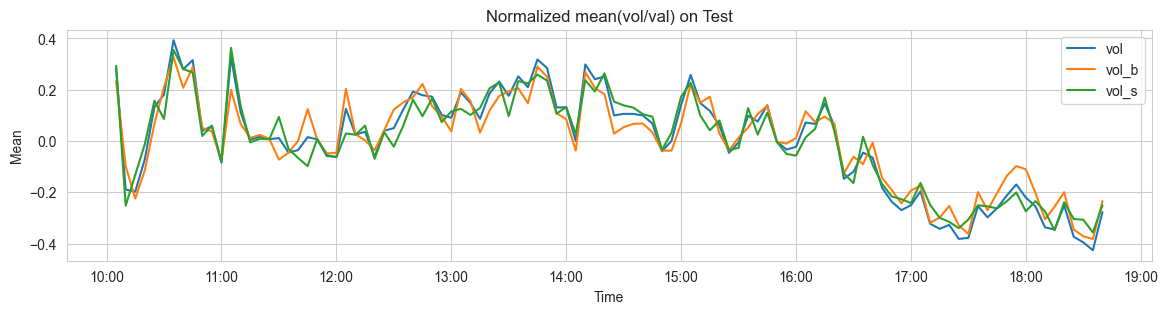

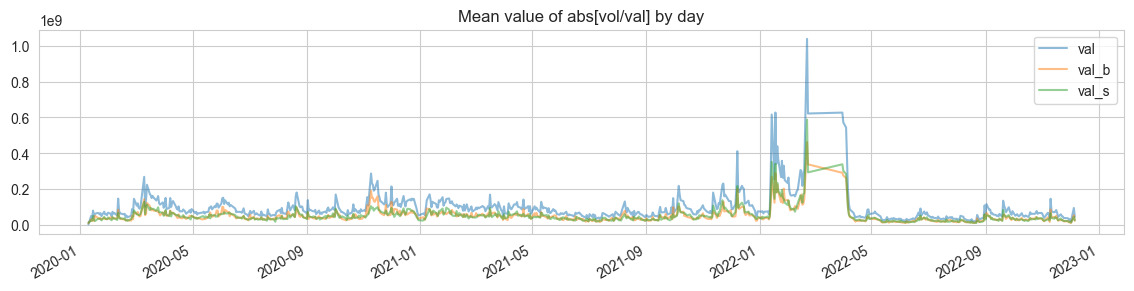

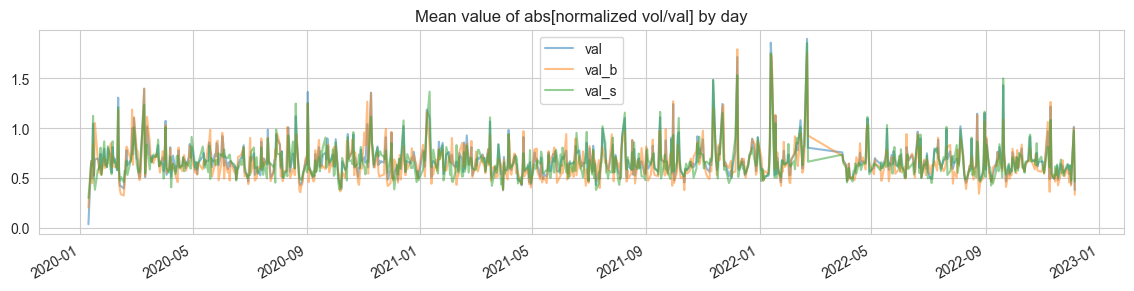

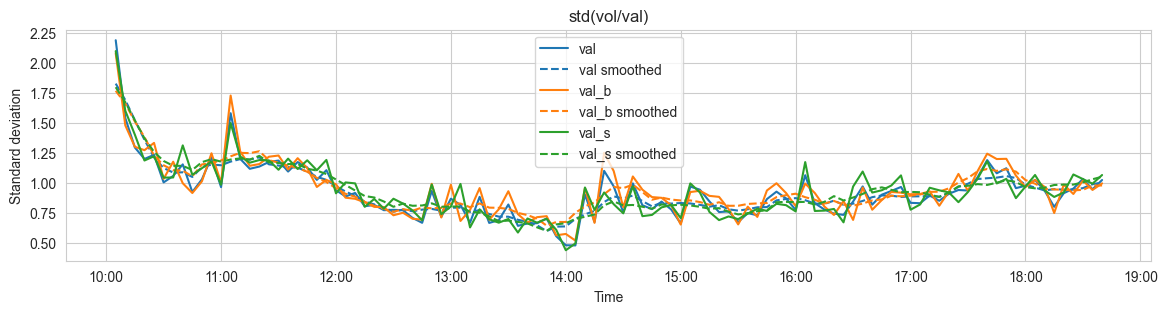

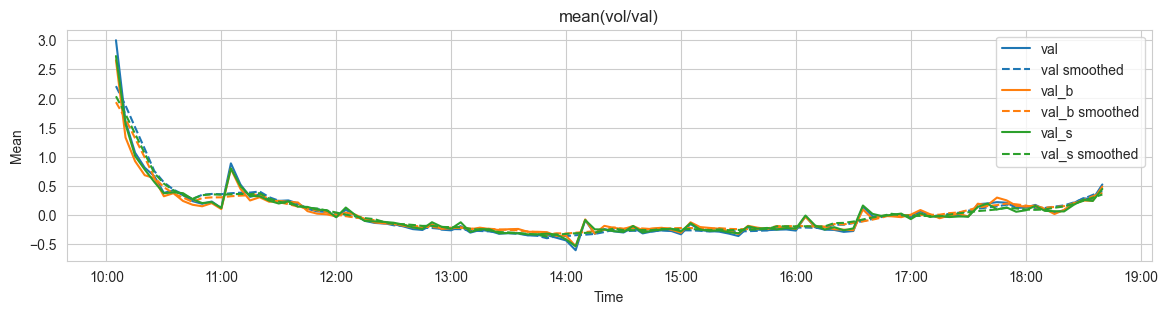

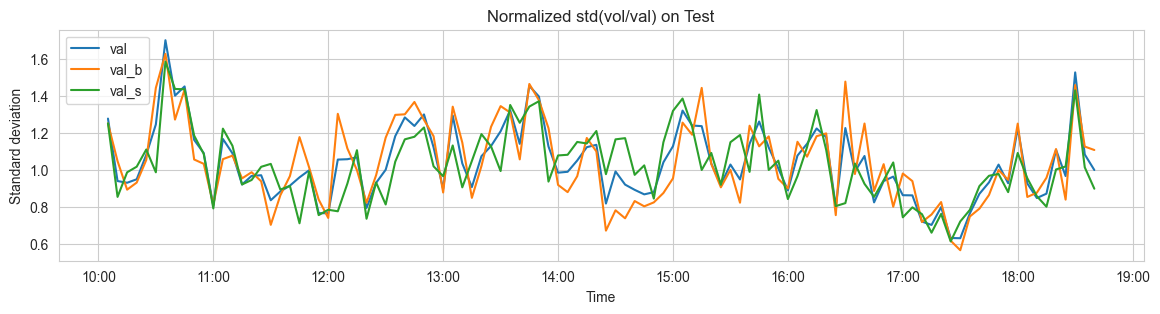

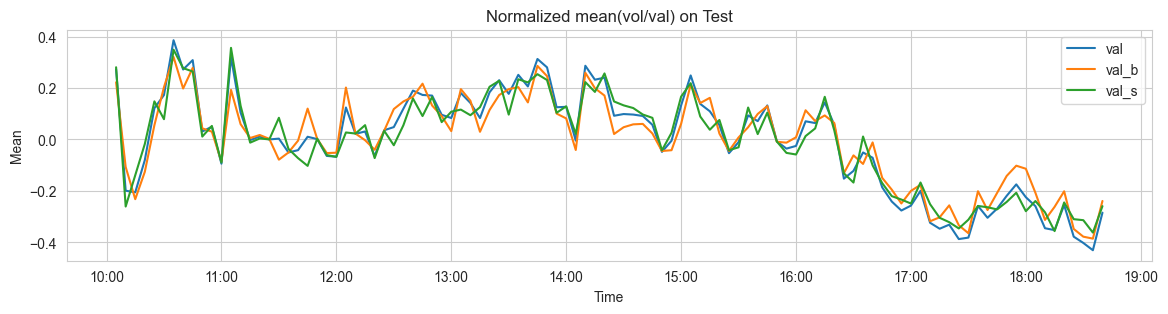

In [17]:
assert (df['vol'] == df['vol_b'] + df['vol_s']).all()


def get_vol_val_b_ratios(features: pd.DataFrame):
    assert (features.columns == ['val', 'vol', 'val_b', 'vol_b']).all()
    return pd.DataFrame({
        'vol_b_ratio': features['vol_b'] / features['vol'],
        'val_b_ratio': features['val_b'] / features['val']
    })


plot_features(get_vol_val_b_ratios(df[['val', 'vol', 'val_b', 'vol_b']]), title='vol/val ratio')
plot_features(df, cols=['vol', 'vol_b', 'vol_s'], title='vol/val')
plot_features(df, cols=['val', 'val_b', 'val_s'], title='vol/val')

## trades

In [18]:
assert (df['trades_b'] + df['trades_s'] == df['trades']).all()


def get_trades_buy_ratio(df):
    assert (df.columns == ['trades_b', 'trades']).all()
    return pd.DataFrame({'buy_trades_ratio': df['trades_b'] / df['trades']}, index=df.index)

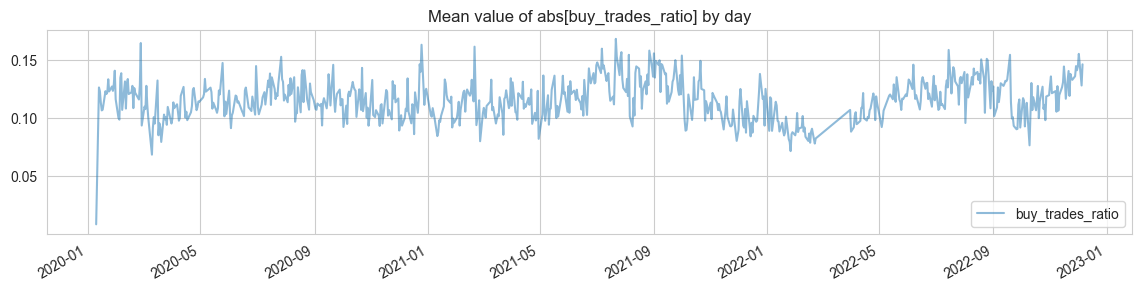

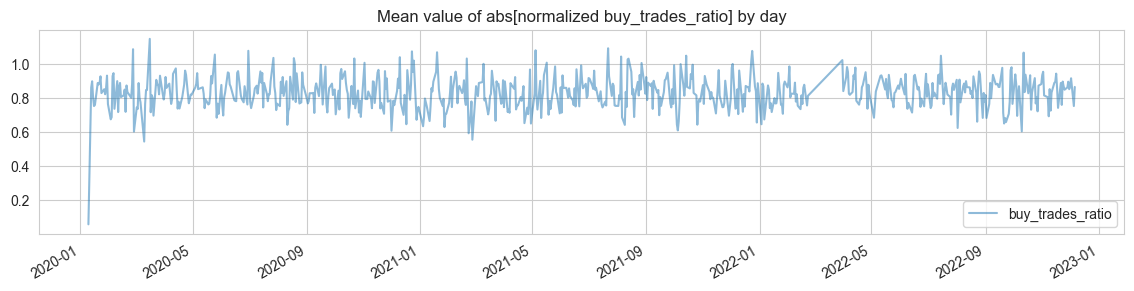

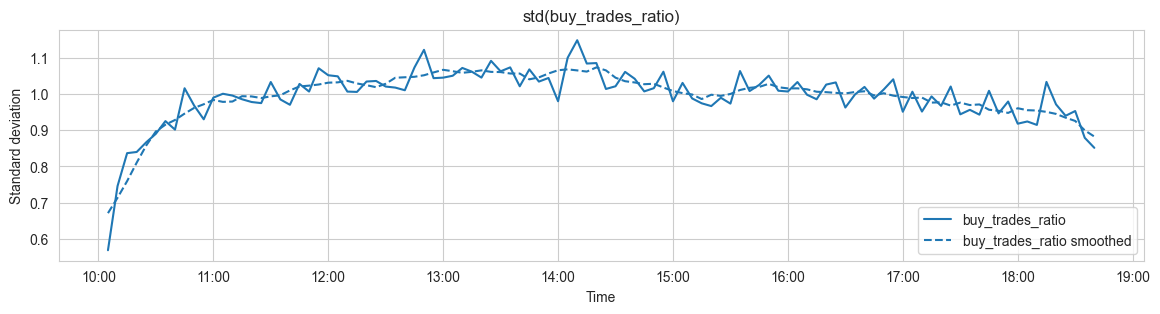

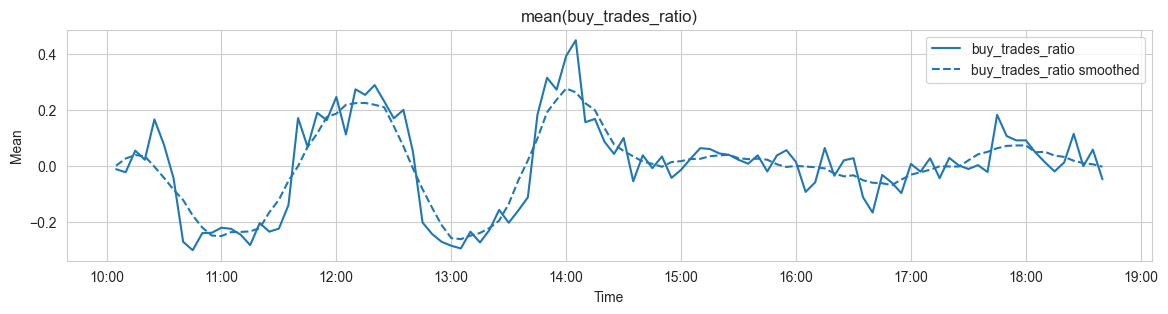

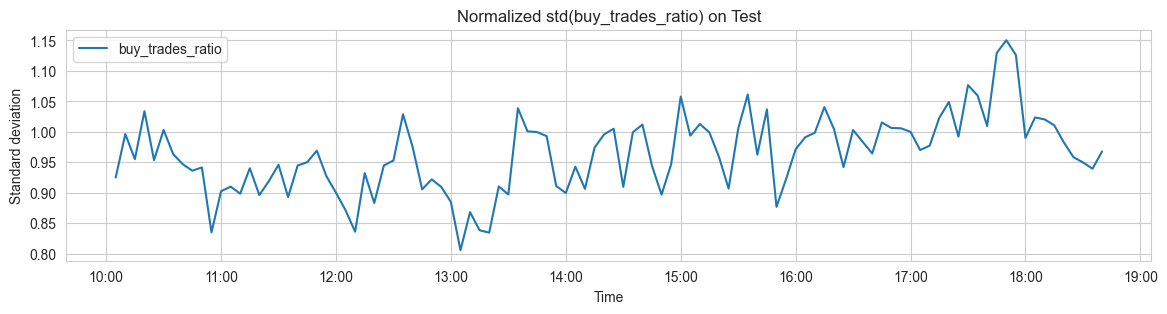

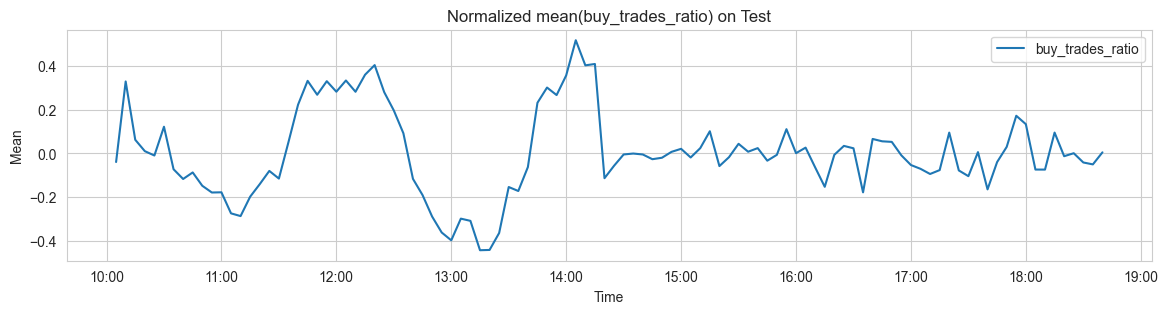

In [19]:
plot_features(get_trades_buy_ratio(df[['trades_b', 'trades']]), use_mean=True)

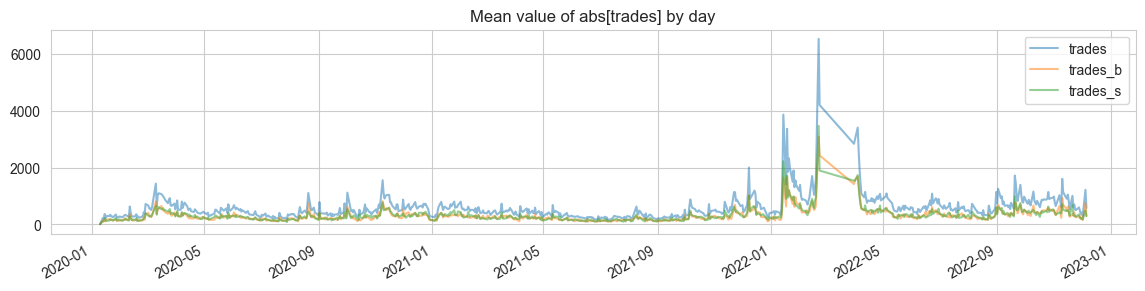

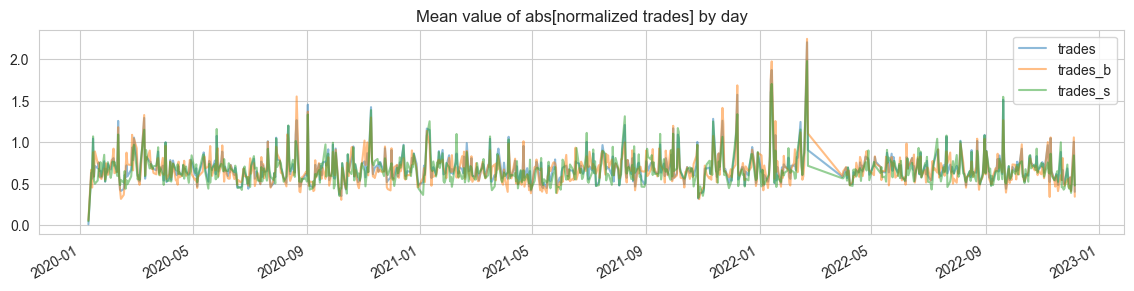

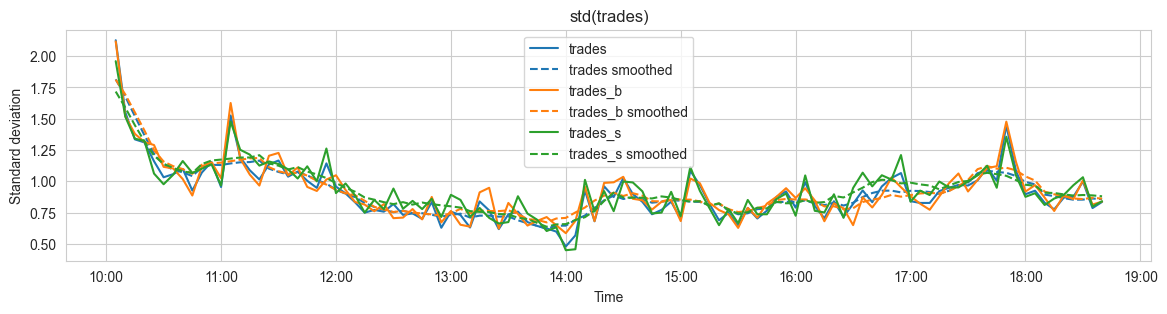

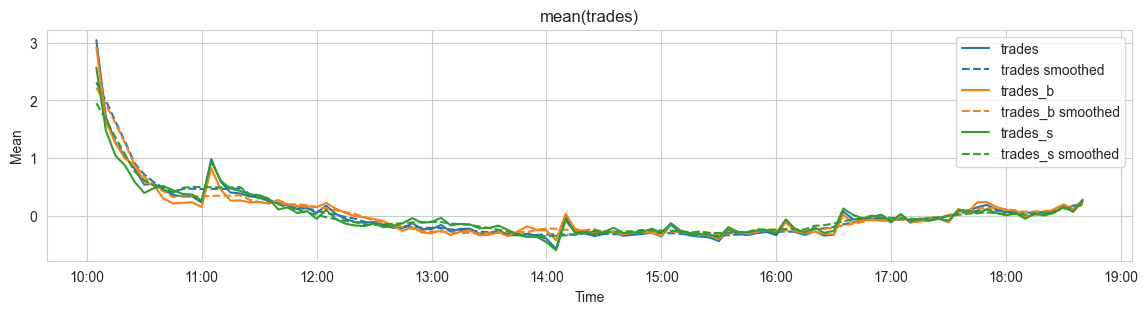

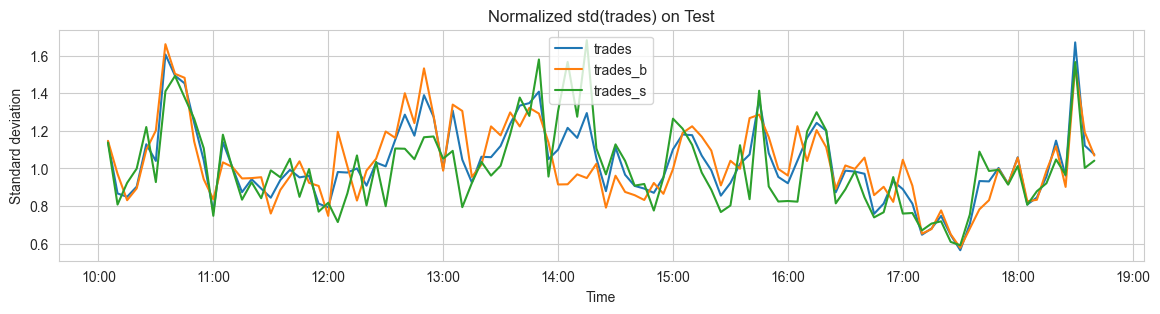

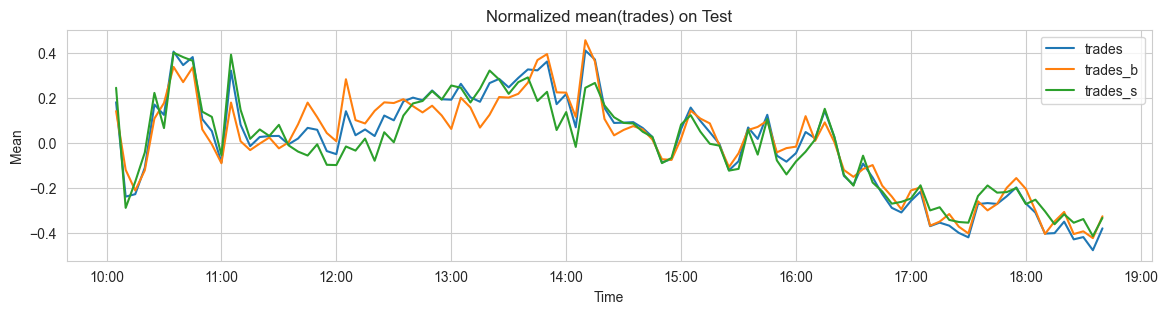

In [20]:
plot_features(df, cols=['trades', 'trades_b', 'trades_s'])

## pr_vwap

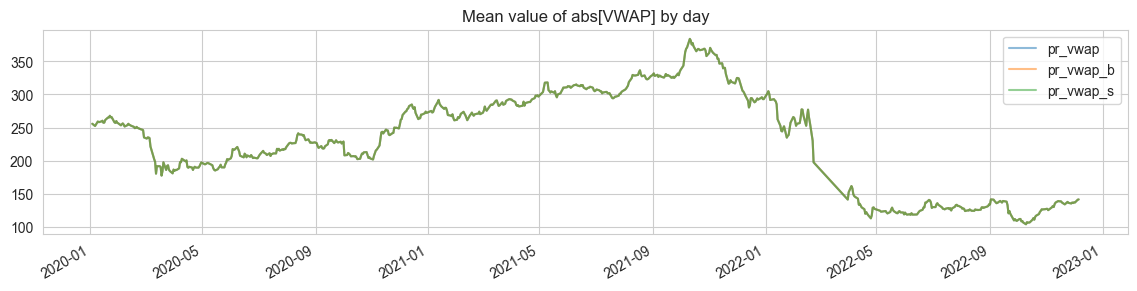

In [21]:
plot_features_by_date(df[VWAP_COLS], 'VWAP')

In [22]:
def transform_vwap(features: pd.DataFrame):
    assert (features.columns == VWAPC_COLS).all()
    new_features = {}
    for col in VWAP_COLS:
        new_features[f"log({col}) - log(close)"] = np.log(features[col]) - np.log(features['pr_close'])
    return pd.DataFrame(new_features)

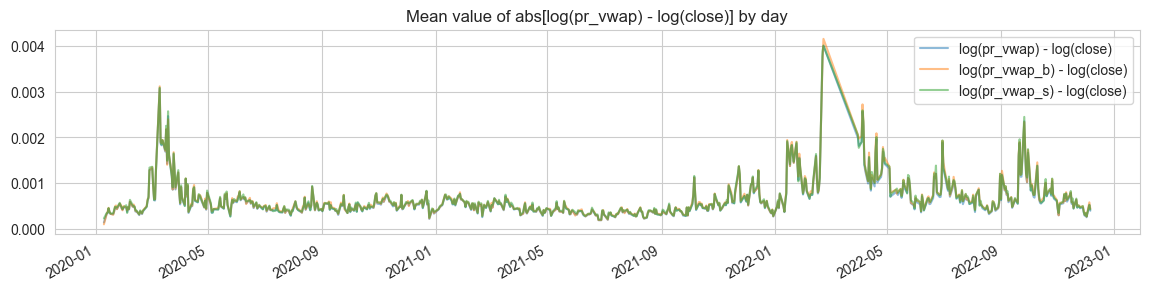

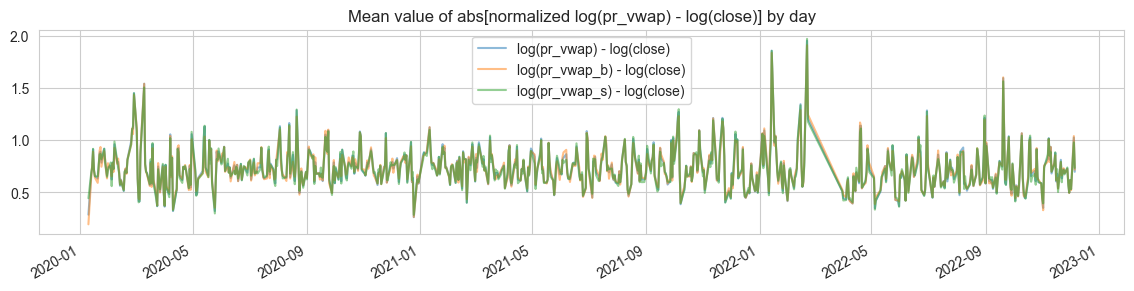

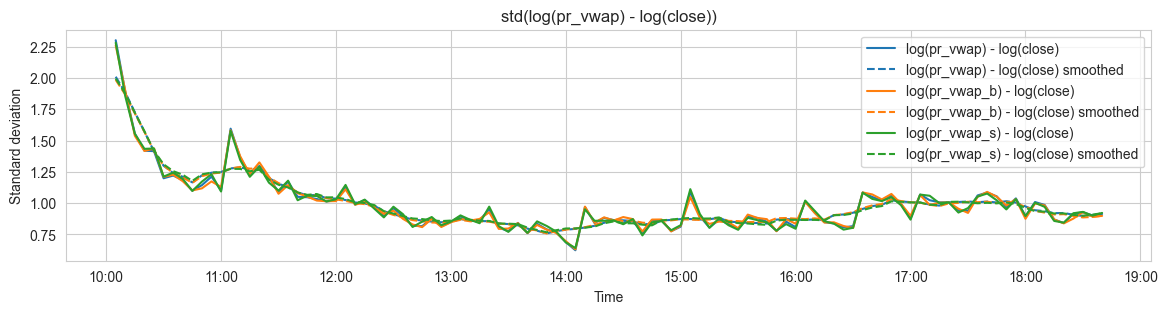

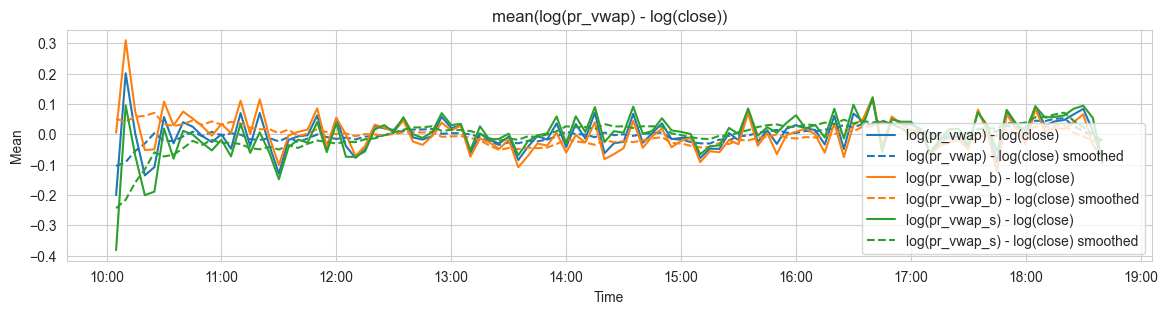

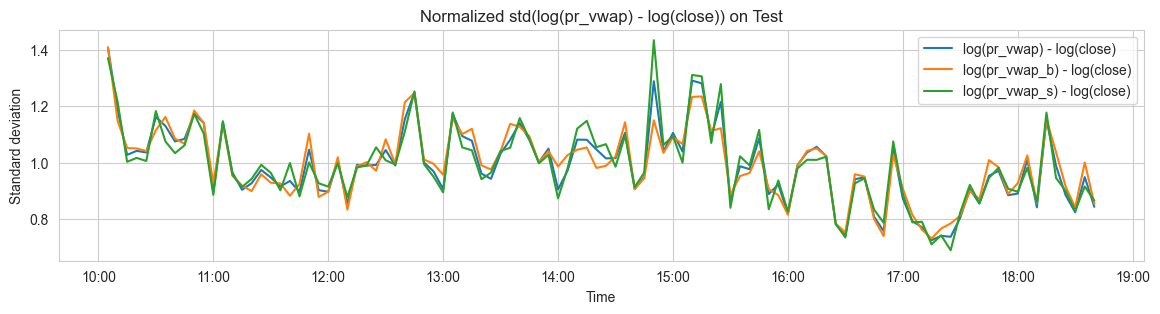

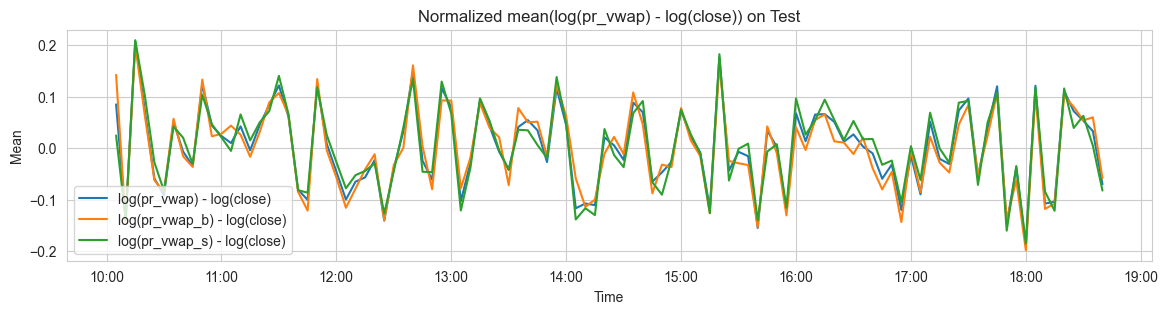

In [23]:
plot_features(transform_vwap(df[VWAPC_COLS]))

## pr_change

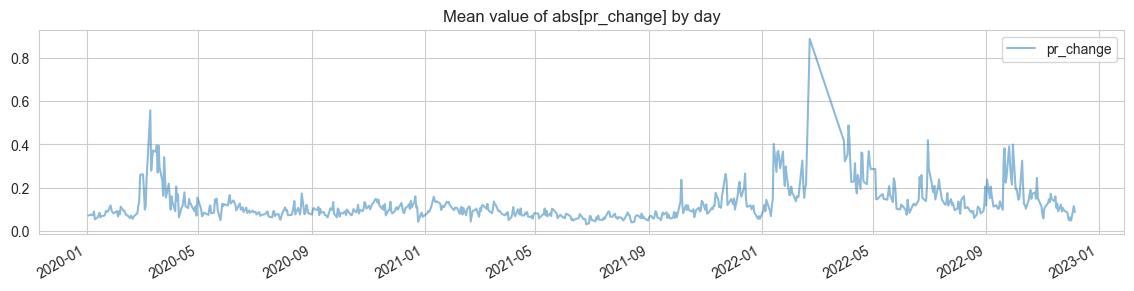

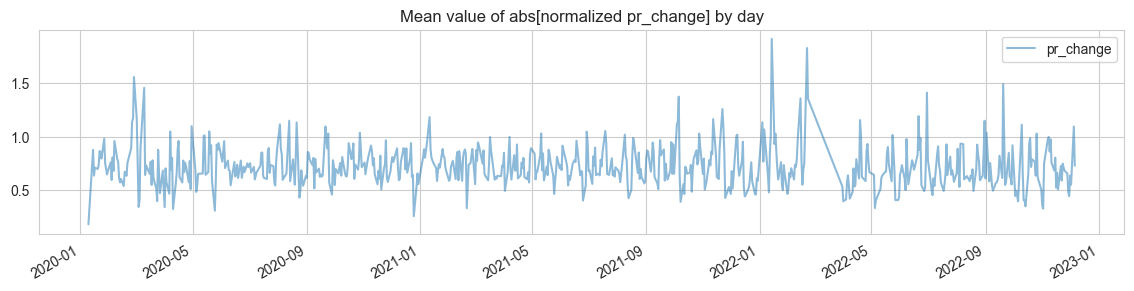

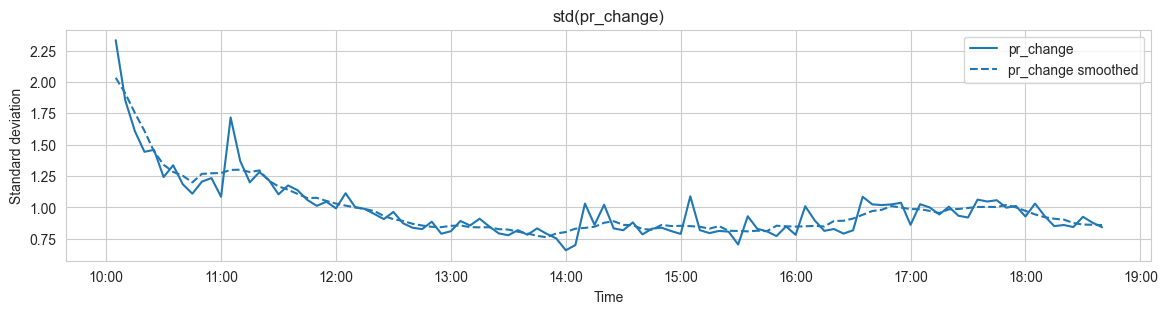

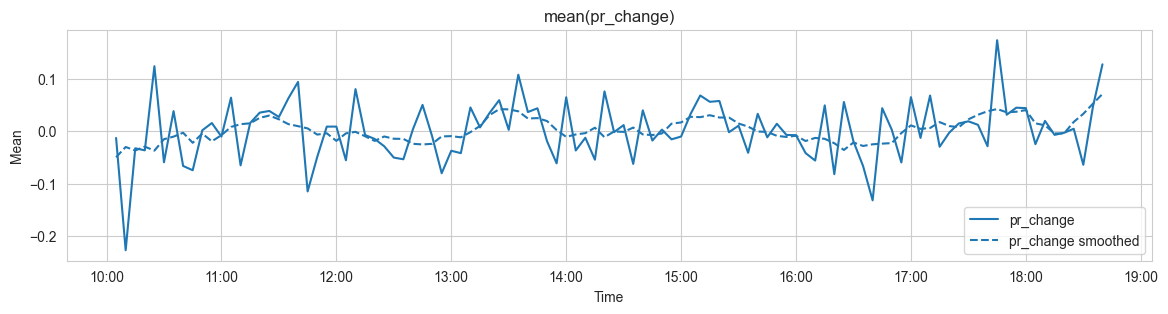

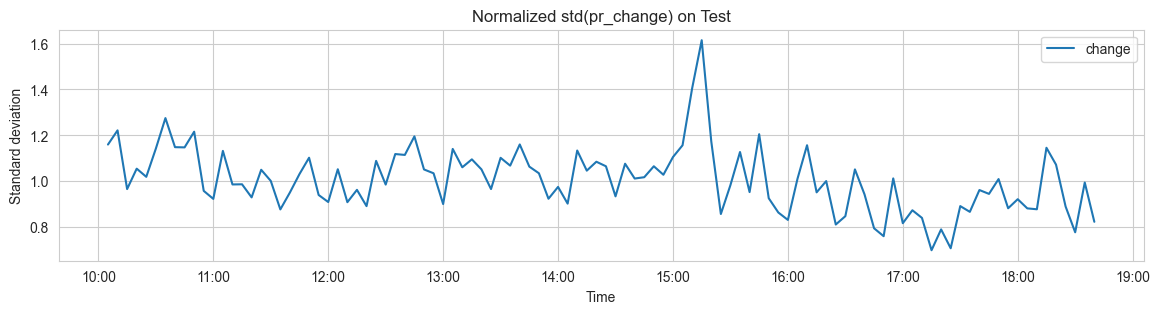

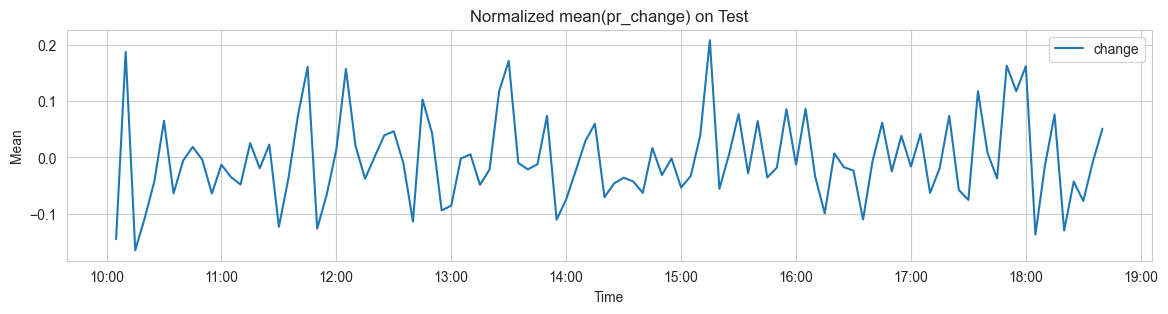

In [24]:
plot_features(df[['pr_change']], use_mean=False)

## disb

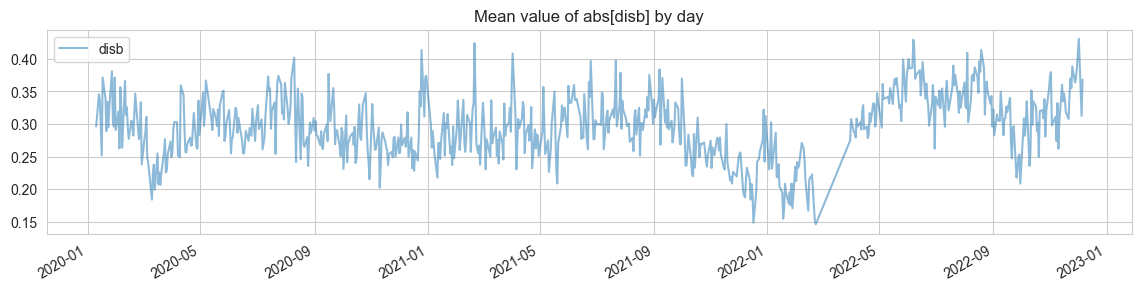

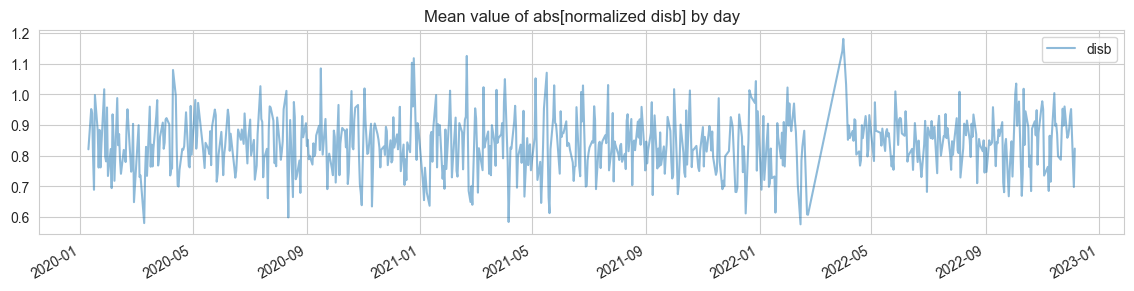

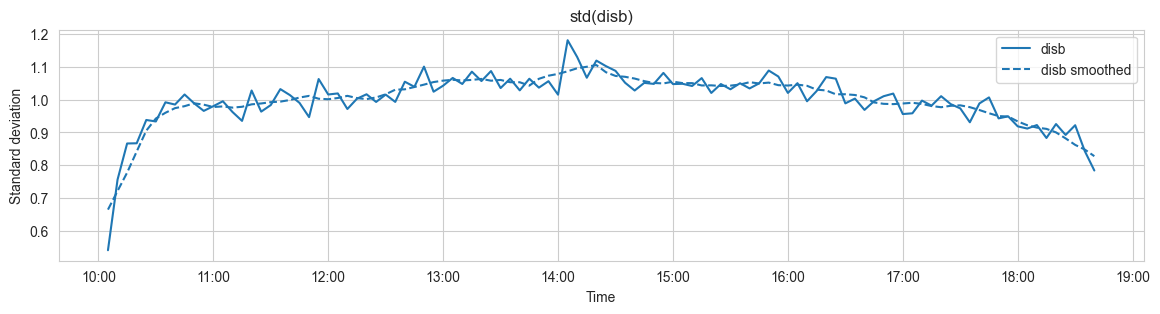

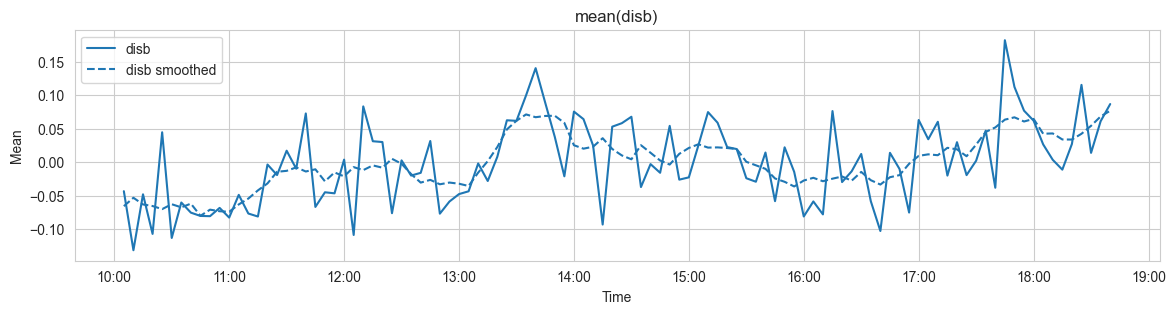

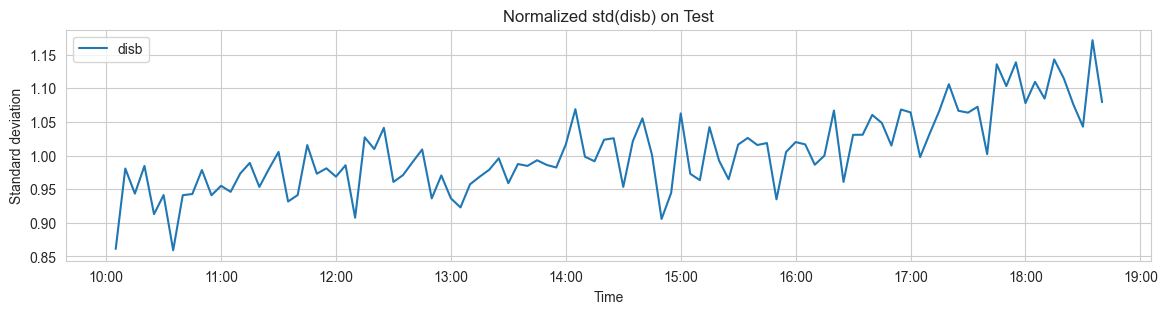

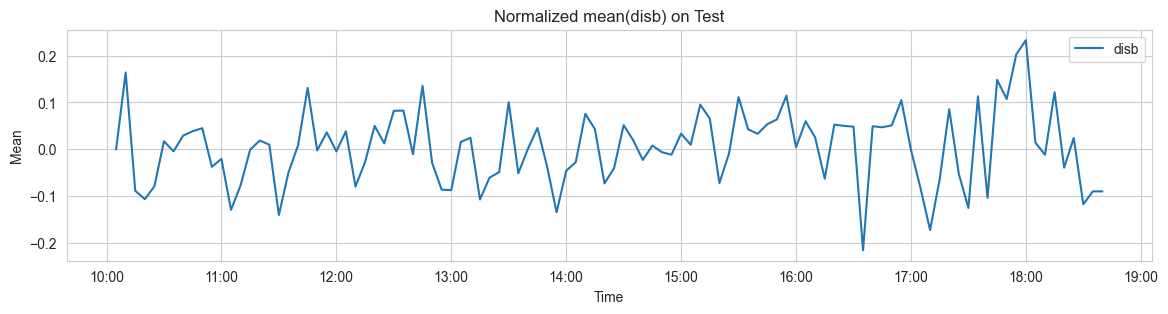

In [25]:
plot_features(df[['disb']])

## Other

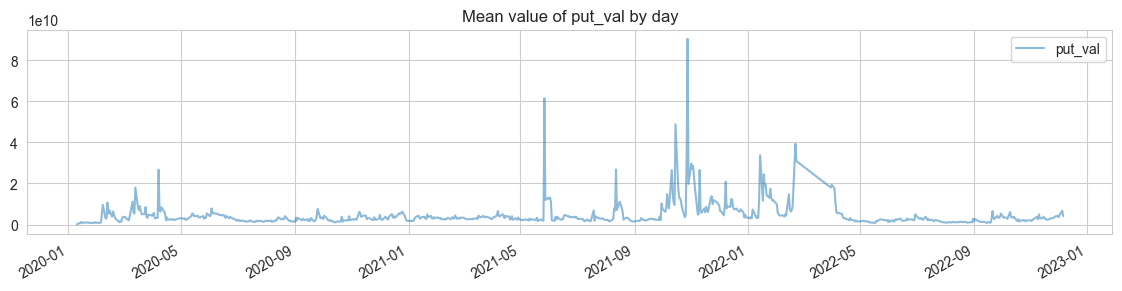

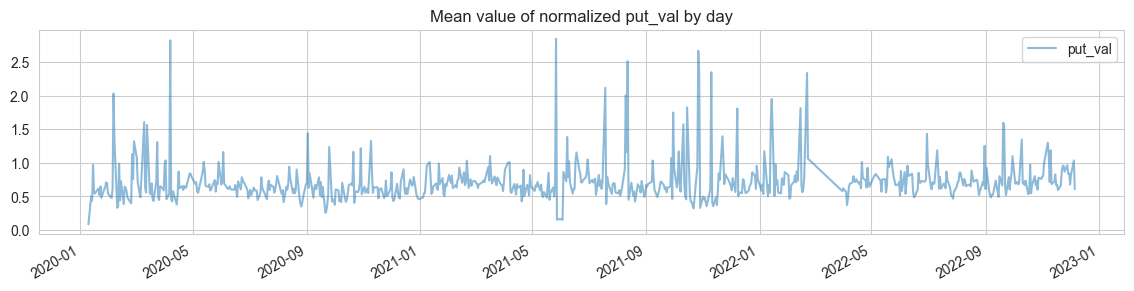

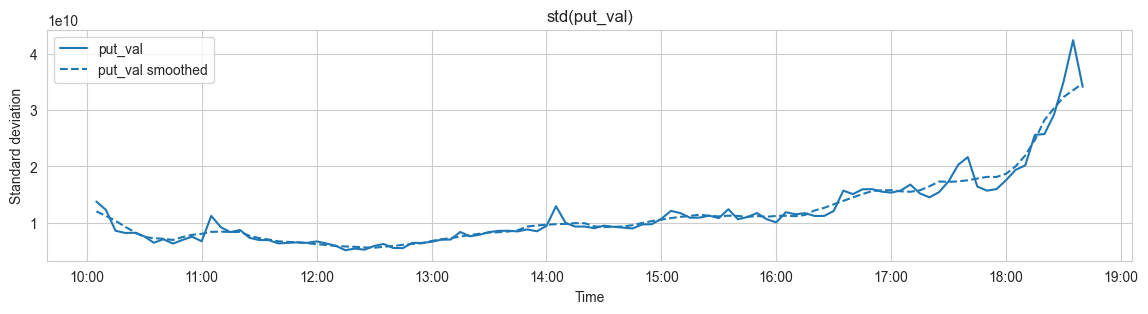

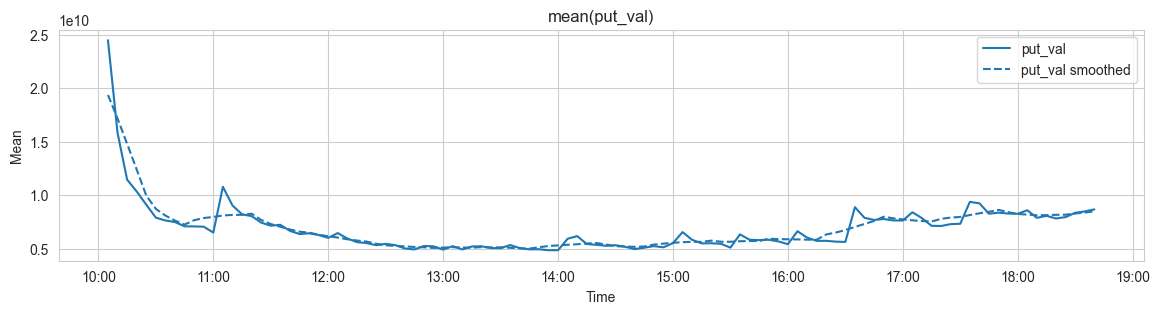

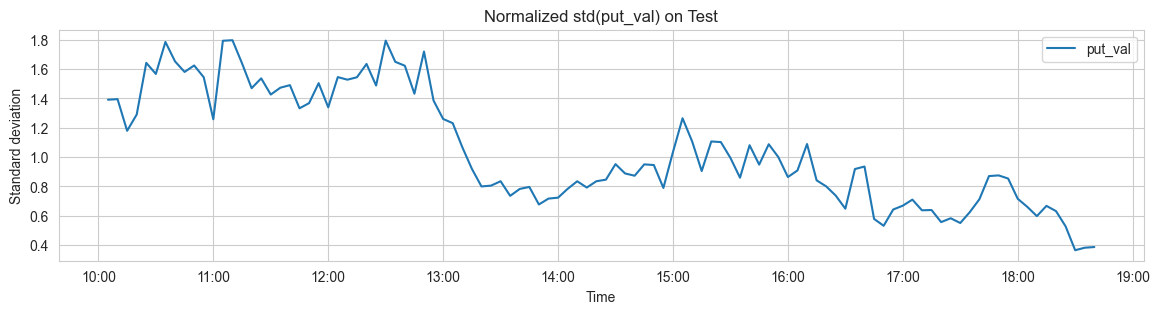

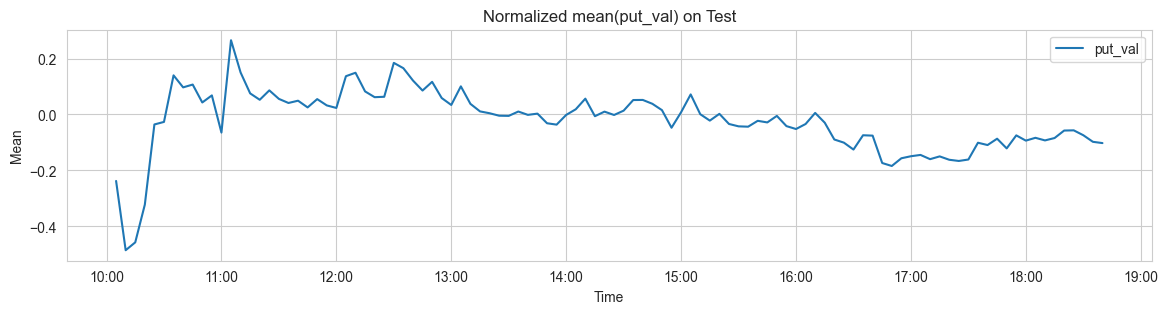

In [301]:
normalize_by_date(stats['orderstats'][['put_val']], n_window_days=DAYS_WINDOW_SIZE, use_mean=True, plot=True, title='put_val')
_ = normalize_by_day_time(stats['orderstats'][['put_val']], smooth_window_size=TIME_SMOOTH_WINDOW_SIZE, use_mean=True, plot=True, title='put_val')

# Normalize features

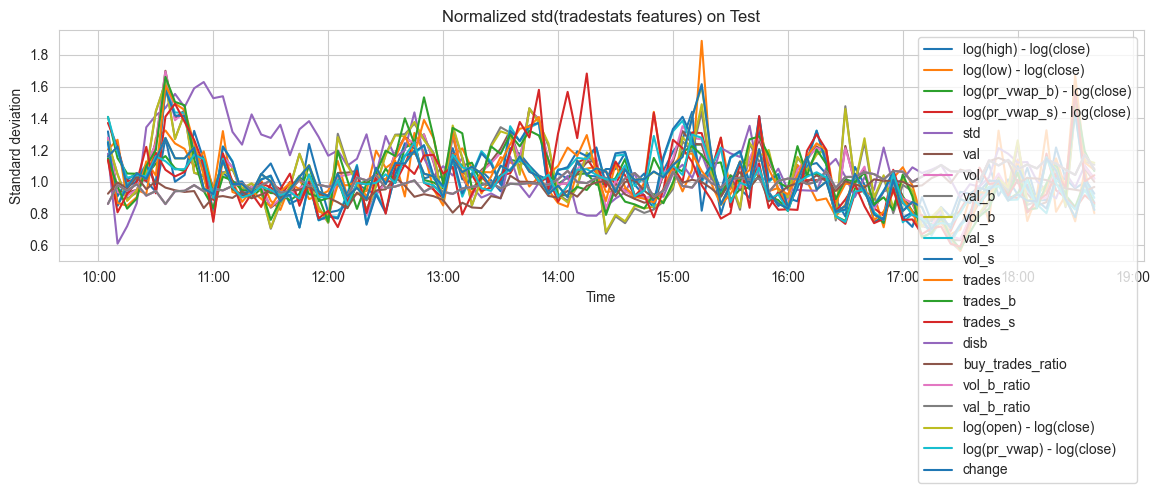

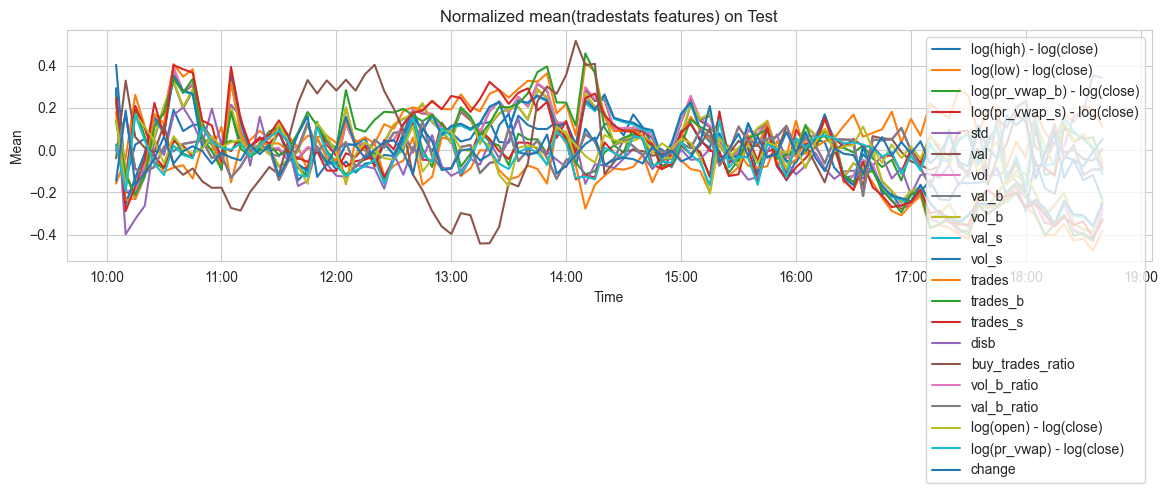

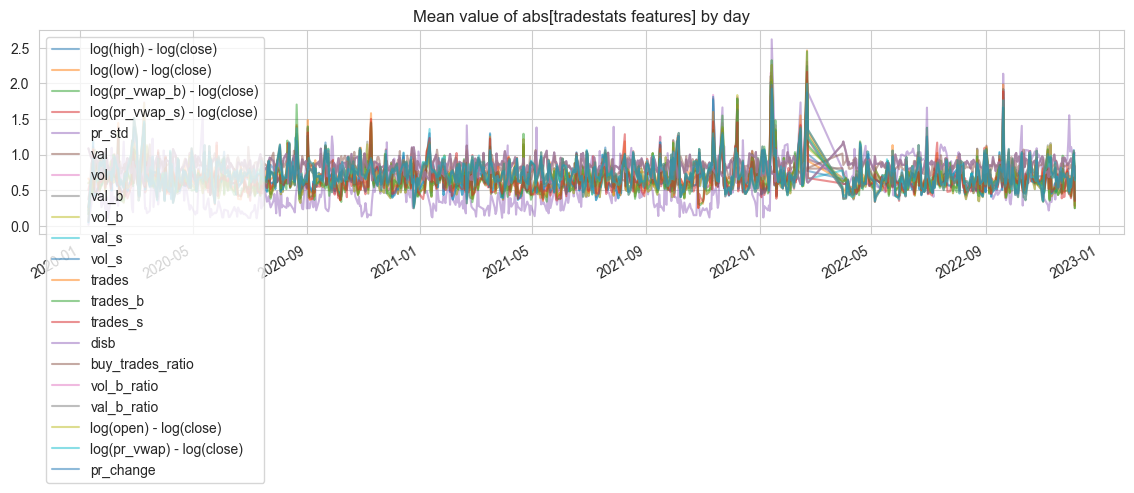

In [30]:
def normalize_tradestats(df: pd.DataFrame) -> pd.DataFrame:
    # OHLC
    ohlc_df = transform_ohlc(df[OHLC_COLS])

    # VWAP
    vwap_df = transform_vwap(df[VWAPC_COLS])

    # Trades Ratio
    trades_ratio_df = get_trades_buy_ratio(df[['trades_b', 'trades']])

    # Vol Ratio
    val_vol_ratio_df = get_vol_val_b_ratios(df[['val', 'vol', 'val_b', 'vol_b']])

    with_mean_df = pd.concat([
        ohlc_df[['log(high) - log(close)', 'log(low) - log(close)']],
        vwap_df[['log(pr_vwap_b) - log(close)', 'log(pr_vwap_s) - log(close)']],
        df[['pr_std', 'val', 'vol', 'val_b', 'vol_b', 'val_s', 'vol_s', 'trades', 'trades_b', 'trades_s', 'disb']],
        trades_ratio_df,
        val_vol_ratio_df
    ], axis=1)
    without_mean_df = pd.concat([
        ohlc_df[['log(open) - log(close)']],
        vwap_df[['log(pr_vwap) - log(close)']],
        df[['pr_change']],
    ], axis=1)

    norm_with_mean_df = normalize_by_day_time(
        normalize_by_date(
            with_mean_df,
            n_window_days=DAYS_WINDOW_SIZE
        ),
        smooth_window_size=TIME_SMOOTH_WINDOW_SIZE
    )
    norm_without_mean_df = normalize_by_day_time(
        normalize_by_date(
            without_mean_df,
            use_mean=False,
            n_window_days=DAYS_WINDOW_SIZE
        ),
        use_mean=False,
        smooth_window_size=TIME_SMOOTH_WINDOW_SIZE
    )

    return pd.concat([norm_with_mean_df, norm_without_mean_df], axis=1)


tmp = normalize_tradestats(stats['tradestats'])
plot_features_mean_std_by_day_time(tmp, title='tradestats features')
plot_features_by_date(tmp, 'tradestats features')

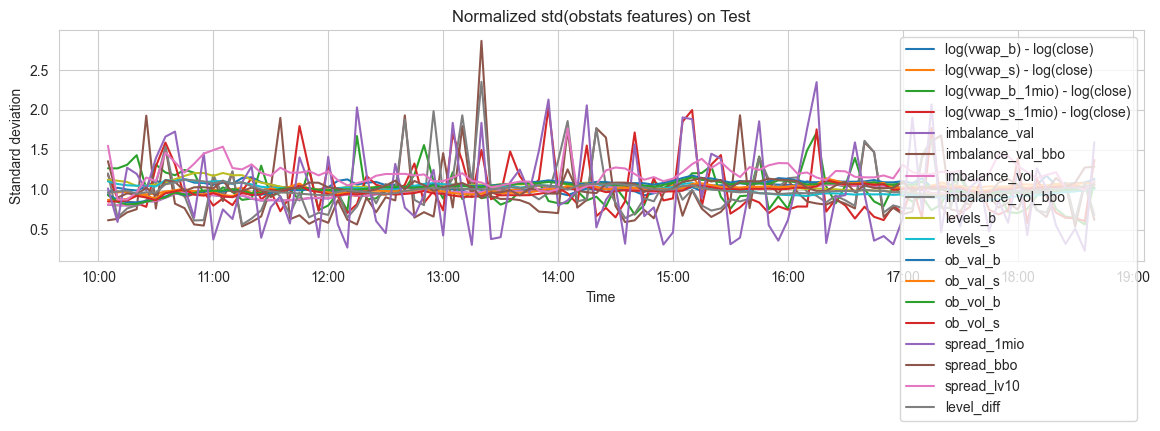

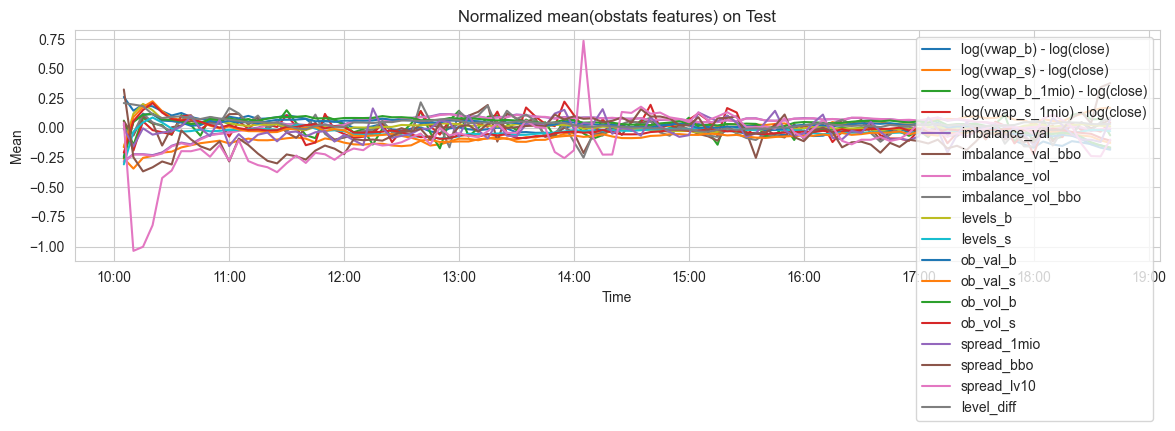

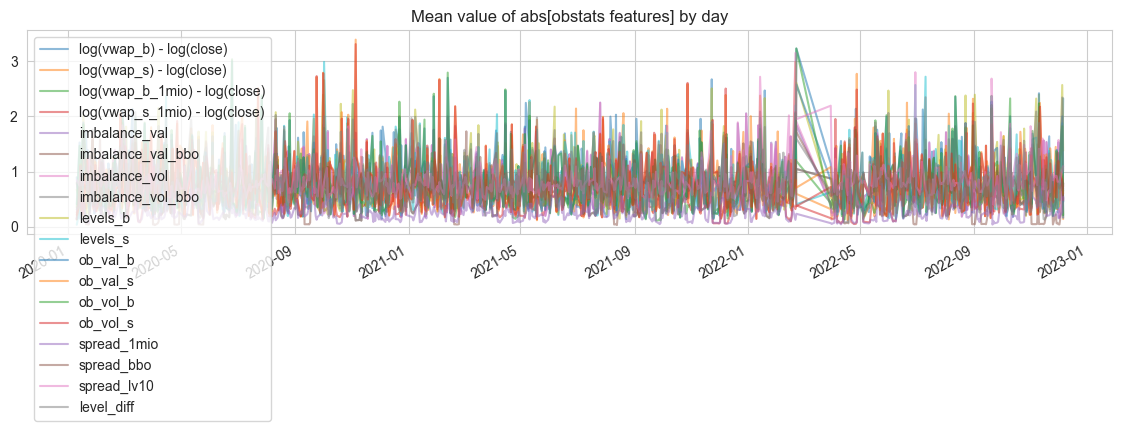

In [49]:
def take_log_diff_close(features: pd.DataFrame, close: pd.Series):
    new_features = {}
    for col in features.columns:
        new_features[f"log({col}) - log(close)"] = np.log(features[col]) - np.log(close)
    return pd.DataFrame(new_features)


def normalize_ob_stats(df: pd.DataFrame, close: pd.Series):
    assert (df.index == close.index).all()
    df = df.rename({'val': 'ob_val', 'vol': 'ob_vol',
                    'val_b': 'ob_val_b', 'vol_b': 'ob_vol_b',
                    'val_s': 'ob_val_s', 'vol_s': 'ob_vol_s'}, axis=1)

    # VWAP
    vwap_cols = ['vwap_b', 'vwap_s', 'vwap_b_1mio', 'vwap_s_1mio']
    vwap_df = take_log_diff_close(df[vwap_cols], close)

    # Level diff
    level_diff = pd.DataFrame({'level_diff': df['levels_b'] - df['levels_s']})

    # Other features
    other_df = df[sorted(set(df.columns) - set(vwap_cols))]

    with_mean_df = pd.concat([
        vwap_df,
        other_df,
        level_diff
    ], axis=1)
    with_mean_df.loc[test_ind]
    assert (with_mean_df.index == close.index).all()

    return normalize_by_day_time(
        normalize_by_date(
            with_mean_df,
            n_window_days=DAYS_WINDOW_SIZE
        ),
        smooth_window_size=TIME_SMOOTH_WINDOW_SIZE
    )


tmp = normalize_ob_stats(stats['obstats'], stats['tradestats']['pr_close'])
plot_features_mean_std_by_day_time(tmp, title='obstats features')
plot_features_by_date(tmp, 'obstats features')

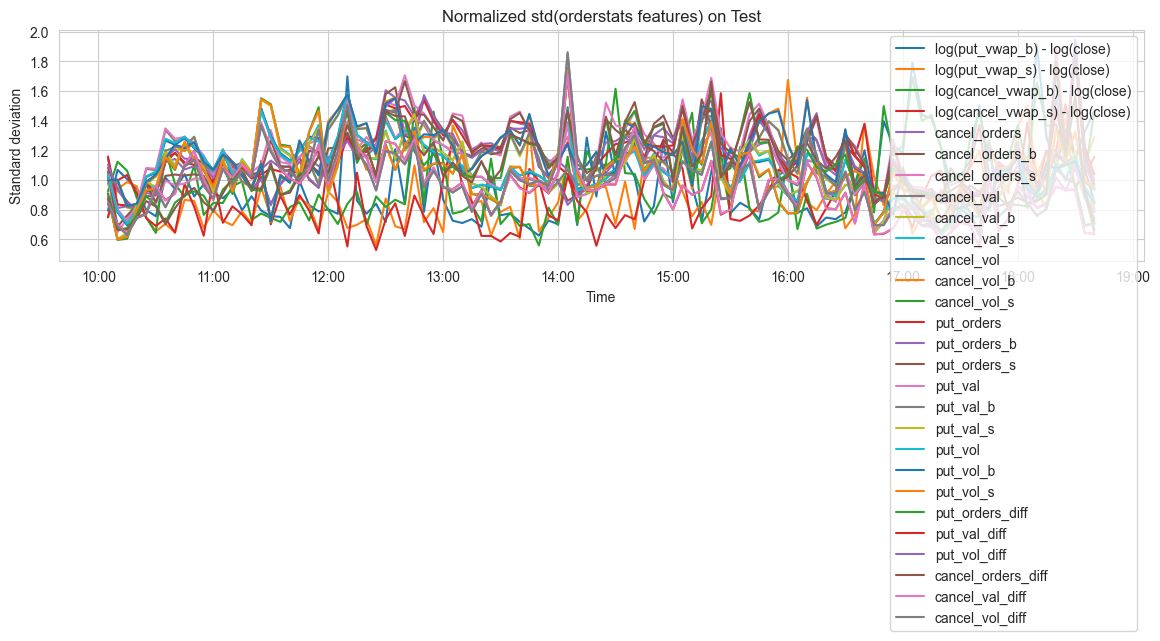

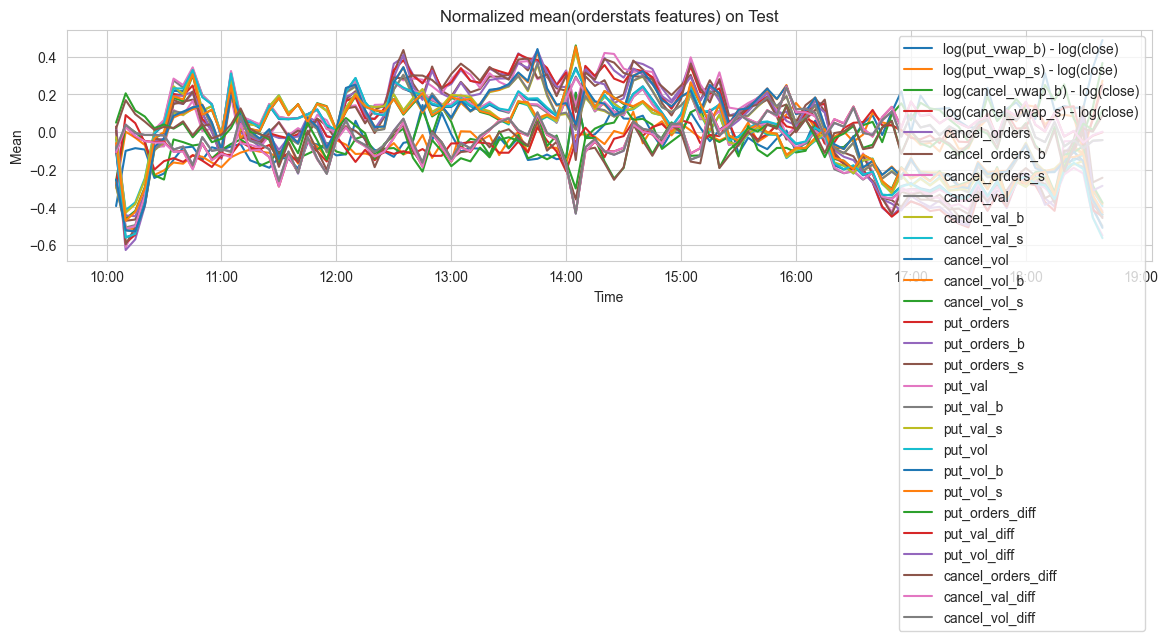

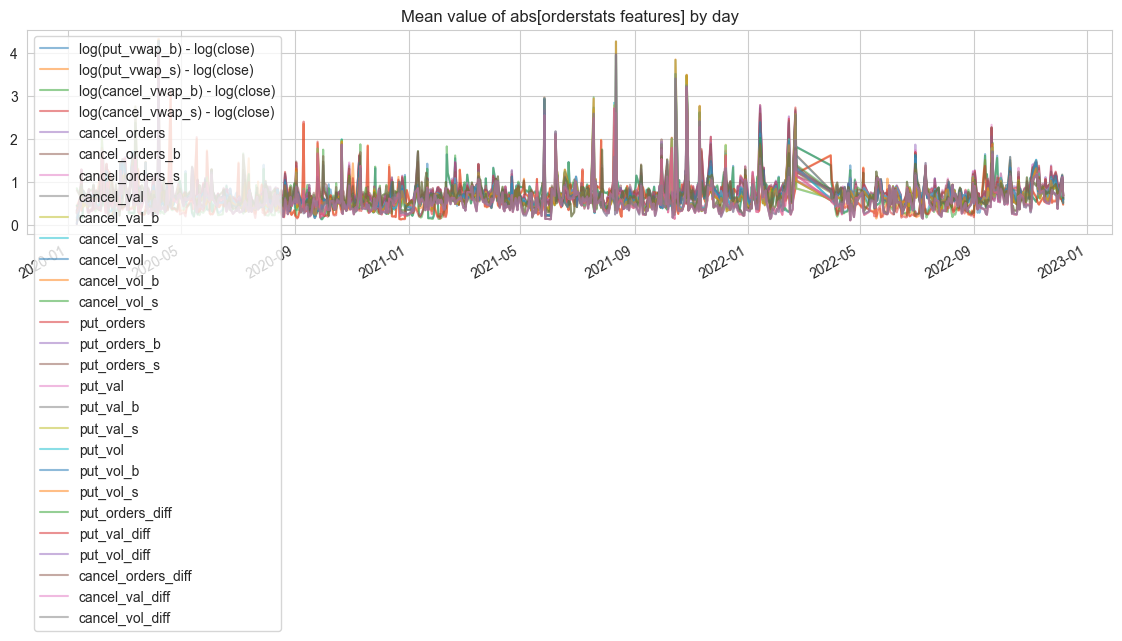

In [176]:
def normalize_order_stats(df: pd.DataFrame, close: pd.Series):
    assert (df.index == close.index).all()
    df = df.rename({'val': 'ob_val', 'vol': 'ob_vol',
                    'val_b': 'ob_val_b', 'vol_b': 'ob_vol_b',
                    'val_s': 'ob_val_s', 'vol_s': 'ob_vol_s'}, axis=1)

    # VWAP
    vwap_cols = [col for col in df.columns if 'vwap' in col]
    vwap_df = take_log_diff_close(df[vwap_cols], close)

    # Level diff
    features_diff = {}
    for col in ['put_orders', 'put_val', 'put_val', 'put_vol', 'cancel_orders', 'cancel_val', 'cancel_vol']:
        features_diff[f'{col}_diff'] = df[f'{col}_b'] - df[f'{col}_s']
    features_diff = pd.DataFrame(features_diff)

    # Other features
    other_df = df[sorted(set(df.columns) - set(vwap_cols))]

    with_mean_df = pd.concat([
        vwap_df,
        other_df,
        features_diff
    ], axis=1)
    with_mean_df.loc[test_ind]
    assert (with_mean_df.index == close.index).all()

    return normalize_by_day_time(
        normalize_by_date(
            with_mean_df,
            n_window_days=DAYS_WINDOW_SIZE
        ),
        smooth_window_size=TIME_SMOOTH_WINDOW_SIZE
    )


tmp = normalize_order_stats(stats['orderstats'], stats['tradestats']['pr_close'])
plot_features_mean_std_by_day_time(tmp, title='orderstats features')
plot_features_by_date(tmp, 'orderstats features')

In [238]:
tradestats_norm = normalize_tradestats(stats['tradestats'])
obstats_norm = normalize_ob_stats(stats['obstats'], stats['tradestats']['pr_close'])
orderstats_norm = normalize_order_stats(stats['orderstats'], stats['tradestats']['pr_close'])
X = pd.concat([tradestats_norm, obstats_norm], axis=1)
X['time_from_start'] = [(t.hour * 60 + t.minute) - 60 * 10 for t in X.index.time]
X.tail()

log(high) - log(close)  log(low) - log(close)  \
time                                                                 
2022-12-06 18:20:00               -0.046545               0.173095   
2022-12-06 18:25:00               -0.473692              -0.066799   
2022-12-06 18:30:00               -0.560376               0.529163   
2022-12-06 18:35:00                1.347053               0.622943   
2022-12-06 18:40:00               -0.359696              -0.004022   

                     log(pr_vwap_b) - log(close)  log(pr_vwap_s) - log(close)  \
time                                                                            
2022-12-06 18:20:00                     0.274646                     0.248682   
2022-12-06 18:25:00                    -0.712991                     0.144507   
2022-12-06 18:30:00                     0.065546                     0.441160   
2022-12-06 18:35:00                     2.521312                     1.401511   
2022-12-06 18:40:00                    -0.033755                     0.209184   

                       pr_std       val       vol     val_b     vol_b  \
time                                                                    
2022-12-06 18:20:00  0.841473 -0.532834 -0.536335 -0.484580 -0.488192   
2022-12-06 18:25:00 -1.150021 -0.352306 -0.357734 -0.323776 -0.329321   
2022-12-06 18:30:00  0.670804 -0.667532 -0.671302 -0.588900 -0.593254   
2022-12-06 18:35:00  0.593363 -0.538436 -0.543588 -0.569670 -0.574882   
2022-12-06 18:40:00  0.517048 -0.490840 -0.496527 -0.463155 -0.469179   

                        val_s  ...  levels_s  ob_val_b  ob_val_s  ob_vol_b  \
time                           ...                                           
2022-12-06 18:20:00 -0.502116  ... -0.105318 -0.149557  0.089137 -0.293419   
2022-12-06 18:25:00 -0.315285  ... -0.105851 -0.150683  0.059425 -0.293805   
2022-12-06 18:30:00 -0.644403  ... -0.168336 -0.176588  0.000403 -0.319052   
2022-12-06 18:35:00 -0.393754  ... -0.104366 -0.225433 -0.065427 -0.366672   
2022-12-06 18:40:00 -0.418790  ...  0.065323 -0.246116 -0.018782 -0.386489   

                     ob_vol_s  spread_1mio  spread_bbo  spread_lv10  \
time                                                                  
2022-12-06 18:20:00 -0.022681    -0.006794    1.204427     0.147153   
2022-12-06 18:25:00 -0.052045    -0.217959   -0.303257    -1.394886   
2022-12-06 18:30:00 -0.110797    -0.435097   -1.035144    -1.844412   
2022-12-06 18:35:00 -0.175818     0.171342    0.643450    -0.549066   
2022-12-06 18:40:00 -0.128249    -0.081911    0.237781     1.077251   

                     level_diff  time_from_start  
time                                              
2022-12-06 18:20:00   -0.469525              500  
2022-12-06 18:25:00   -0.457839              505  
2022-12-06 18:30:00   -0.410295              510  
2022-12-06 18:35:00   -0.442398              515  
2022-12-06 18:40:00   -0.583866              520  

[5 rows x 40 columns]

# Create target

In [239]:
TIME_RANGE[:2], TIME_RANGE[-2:]

([datetime.time(10, 5), datetime.time(10, 10)],
 [datetime.time(18, 35), datetime.time(18, 40)])

In [240]:
def create_target(tradestats: pd.DataFrame, window: int, alpha: float):
    returns = tradestats['pr_close'].pct_change().shift(-2)
    returns[np.isin(returns.index.time, TIME_RANGE[-2:])] = np.nan
    bound = returns.std() * alpha
    target_classes = []
    zero_class_returns = []
    for group, ind in returns.groupby(returns.index.date).groups.items():
        today_returns = returns.loc[ind].values
        assert len(today_returns) == len(TIME_RANGE)
        for i in range(len(TIME_RANGE) - window - 1):
            next_window_returns = today_returns[i:i + window]
            assert np.isfinite(next_window_returns).all()
            next_window_cum_returns = np.cumsum(next_window_returns)
            # Find take profit and stop loss time
            if next_window_cum_returns.max() >= bound:
                profit_time = np.argmax(next_window_cum_returns >= bound)
            else:
                profit_time = None
            if next_window_cum_returns.min() <= -bound:
                loss_time = np.argmax(next_window_cum_returns <= -bound)
            else:
                loss_time = None
            assert profit_time is None and loss_time is None or profit_time != loss_time
            # Check 
            if profit_time is None and loss_time is None:
                target_class = 0
            elif profit_time is not None and loss_time is not None:
                target_class = 1 if profit_time < loss_time else -1
            elif loss_time is None:
                target_class = 1
            elif profit_time is None:
                target_class = -1
            else:
                assert False, 'Unreachable'
            target_classes.append(target_class)
            assert np.isfinite(next_window_cum_returns[-1])
            zero_class_returns.append(next_window_cum_returns[-1])
        target_classes += [np.nan] * (window + 1)
        zero_class_returns += [np.nan] * (window + 1)
    target_classes = pd.Series(target_classes, index=returns.index)
    zero_class_returns = pd.Series(zero_class_returns, index=returns.index)
    return target_classes, zero_class_returns, bound

In [336]:
def clean_dataset(X, y, zero_class_returns):
    assert (np.isnan(y) == np.isnan(zero_class_returns)).all()
    is_X_nan = X.drop(columns=['time_from_start']).isna().all(axis=1)
    is_y_nan = y.isna()
    mask = ~is_X_nan & ~is_y_nan
    X_clean = X[mask]
    y_clean = y[mask]
    zero_class_returns = zero_class_returns[mask]
    assert X_clean.isna().sum().sum() == 0
    assert zero_class_returns.isna().sum() == 0
    return X_clean, y_clean, zero_class_returns


PREDICTION_WINDOW_SIZE = 12
ALPHA = 2
y, zero_class_returns, bound = create_target(stats['tradestats'], window=PREDICTION_WINDOW_SIZE, alpha=ALPHA)

X_train = X.loc[train_ind]
X_test = X.loc[test_ind]
y_train = y.loc[train_ind]
y_test = y.loc[test_ind]
zero_class_returns_train = zero_class_returns.loc[train_ind]
zero_class_returns_test = zero_class_returns.loc[test_ind]

X_train, y_train, zero_class_returns_train = clean_dataset(X_train, y_train, zero_class_returns_train)
X_test, y_test, zero_class_returns_test = clean_dataset(X_test, y_test, zero_class_returns_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1, shuffle=True)

In [337]:
classes_counts = y_train.value_counts() / len(y_train) * 100
classes_counts

 0.0    57.117278
-1.0    21.466940
 1.0    21.415782
Name: count, dtype: float64

In [338]:
print(f'Train length: {X_train.shape}. Validation length: {X_val.shape}. Test length: {X_test.shape}')

Train length: (31276, 40). Validation length: (13405, 40). Test length: (19383, 40)


# Fit Ridge Regression

In [339]:
def print_classification_metrics(y_true, y_pred):
    mask = (y_pred != 0) & (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    score = (y_true == y_pred).mean()
    print(f'Precision on [-1, 1] = {score:.4f}')

Train metrics:
Precision on [-1, 1] = 0.5355

Test metrics:
Precision on [-1, 1] = 0.4672


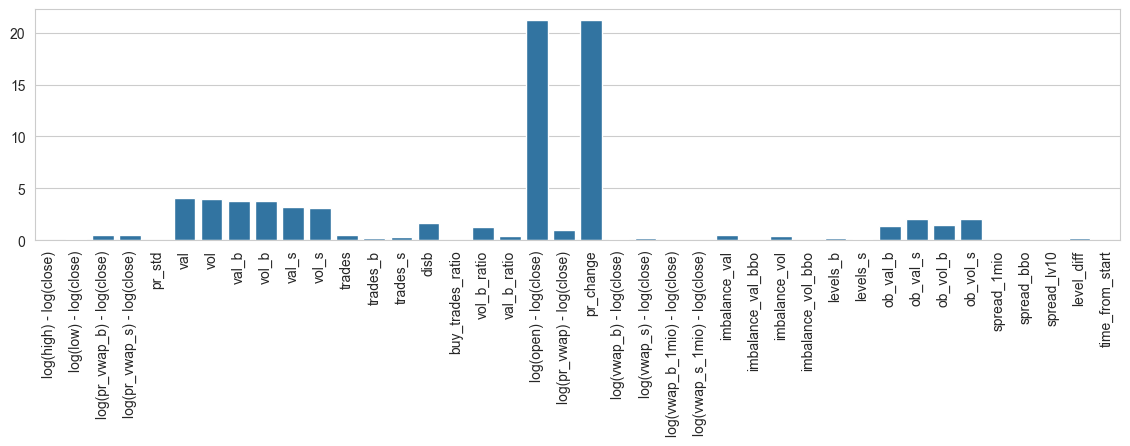

In [340]:
from sklearn.linear_model import RidgeClassifierCV

ridge = RidgeClassifierCV()
ridge.fit(X_train, y_train)

print('Train metrics:')
print_classification_metrics(y_train, ridge.predict(X_train))

print('\nTest metrics:')
print_classification_metrics(y_test, ridge.predict(X_test))

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=ridge.feature_names_in_, y=np.abs(ridge.coef_).sum(axis=0))
plt.xticks(rotation=90)
plt.show()

# Fit CatBoost

In [341]:
from catboost import CatBoostClassifier


model = CatBoostClassifier(iterations=1000, depth=7, random_state=1)
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=300)

Learning rate set to 0.115673
0:	learn: 1.0655087	test: 1.0664478	best: 1.0664478 (0)	total: 38.5ms	remaining: 38.5s
1:	learn: 1.0380288	test: 1.0400774	best: 1.0400774 (1)	total: 69.6ms	remaining: 34.7s
2:	learn: 1.0164216	test: 1.0197138	best: 1.0197138 (2)	total: 99.4ms	remaining: 33s
3:	learn: 0.9993226	test: 1.0036146	best: 1.0036146 (3)	total: 130ms	remaining: 32.5s
4:	learn: 0.9853300	test: 0.9904860	best: 0.9904860 (4)	total: 160ms	remaining: 31.8s
5:	learn: 0.9746512	test: 0.9804233	best: 0.9804233 (5)	total: 189ms	remaining: 31.4s
6:	learn: 0.9652007	test: 0.9714429	best: 0.9714429 (6)	total: 225ms	remaining: 31.9s
7:	learn: 0.9572662	test: 0.9637107	best: 0.9637107 (7)	total: 255ms	remaining: 31.6s
8:	learn: 0.9513289	test: 0.9584246	best: 0.9584246 (8)	total: 284ms	remaining: 31.3s
9:	learn: 0.9445248	test: 0.9519961	best: 0.9519961 (9)	total: 321ms	remaining: 31.7s
10:	learn: 0.9398888	test: 0.9481363	best: 0.9481363 (10)	total: 362ms	remaining: 32.6s
11:	learn: 0.9356581	

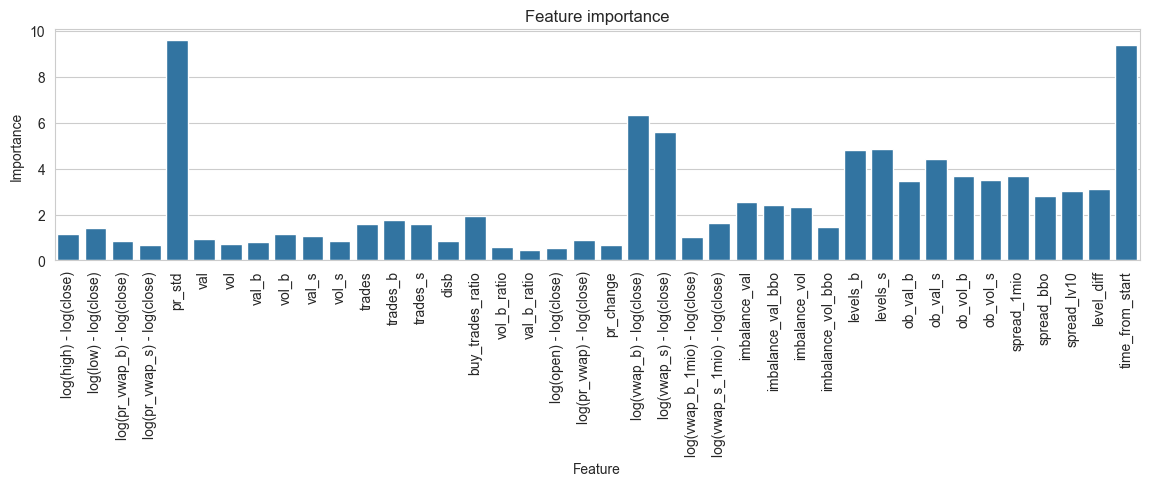

In [342]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=model.feature_names_, y=model.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [343]:
print('Train class balance:')
y_train.value_counts().sort_index() / len(y_train) * 100

Train class balance:


-1.0    21.466940
 0.0    57.117278
 1.0    21.415782
Name: count, dtype: float64

In [344]:
print('Test class balance:')
y_test.value_counts().sort_index() / len(y_test) * 100

Test class balance:


-1.0    34.102048
 0.0    31.847495
 1.0    34.050457
Name: count, dtype: float64

In [345]:
print(f'Model prediction class balance:')
pd.Series(model.predict(X_test).reshape(-1)).value_counts().sort_index() / len(X_test) * 100

Model prediction class balance:


-1.0    23.582521
 0.0    57.008719
 1.0    19.408760
Name: count, dtype: float64

In [346]:
print('Train metrics:')
print_classification_metrics(y_train, model.predict(X_train).reshape(-1))

print('\nTest metrics:')
print_classification_metrics(y_test, model.predict(X_test).reshape(-1))

print(pd.Series(model.predict(X_test).reshape(-1)).value_counts() / len(X_test) * 100)

Train metrics:
Precision on [-1, 1] = 0.9803

Test metrics:
Precision on [-1, 1] = 0.5175


 0.0    57.008719
-1.0    23.582521
 1.0    19.408760
Name: count, dtype: float64


In [379]:
THRESHOLD = 0.8

y_pred = model.predict_proba(X_test)


def get_prediction(prob_minus, prob_zero, prob_plus):
    if prob_minus > THRESHOLD and prob_minus > prob_plus:
        return -1
    if prob_plus > THRESHOLD and prob_plus > prob_minus:
        return 1
    return 0

y_pred = np.array([get_prediction(prob[0], prob[1], prob[2]) for prob in y_pred])
pd.Series(y_pred).value_counts() / len(y_pred) * 100

 0    99.045555
-1     0.572667
 1     0.381778
Name: count, dtype: float64

In [380]:
print_classification_metrics(y_test, y_pred)

Precision on [-1, 1] = 0.5858


# Analyze returns

In [416]:
COMMISSION = 0.04 / 100


def calculate_returns(y_true, y_pred, zero_class_returns, bound):
    pred_mask = (y_pred != 0)
    y_true = y_true[pred_mask]
    y_pred = y_pred[pred_mask]
    zero_class_returns = zero_class_returns[pred_mask]
    returns_long = (y_true == 1) * bound - (y_true == -1) * bound + (y_true == 0) * zero_class_returns
    returns_short = (y_true == -1) * bound - (y_true == 1) * bound - (y_true == 0) * zero_class_returns
    return (y_pred == 1) * returns_long + (y_pred == -1) * returns_short


def get_daily_returns(strategy_returns: pd.Series) -> pd.Series:
    assert strategy_returns.isna().sum() == 0
    day_returns = strategy_returns.groupby(strategy_returns.index.date).sum()
    days = sorted(set(test_ind.date))
    day_returns = day_returns.reindex(days).fillna(0)
    return day_returns


strategy_returns = calculate_returns(y_test, y_pred, zero_class_returns_test, bound) - 2 * COMMISSION  # Enter and exit the trade with commission
strategy_daily_returns = get_daily_returns(strategy_returns)

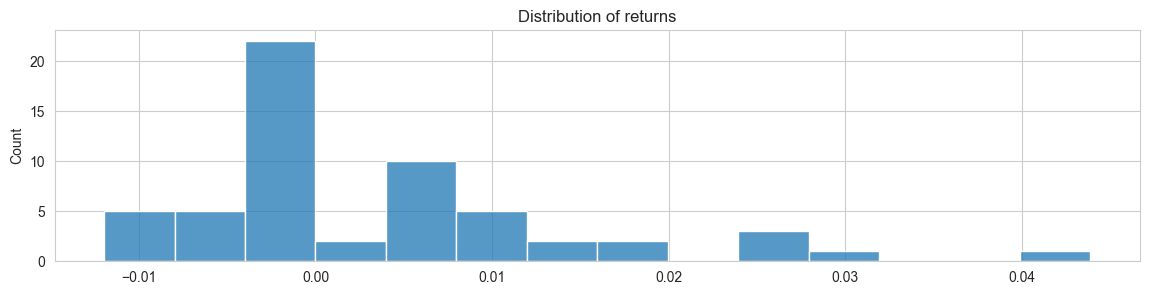

<Figure size 1400x300 with 0 Axes>

In [417]:
plt.figure(figsize=FIG_SIZE)
sns.histplot(strategy_daily_returns[strategy_daily_returns != 0])
plt.title('Distribution of returns')
plt.show()
plt.figure(figsize=FIG_SIZE)
# strategy_daily_returns.cumsum().plot()
# plt.title('Cumulative returns')
# plt.ylabel('Cumulative Return')
plt.show()

In [421]:
N_TRADING_DAYS_PER_YEAR = 252
N_TRADING_DAYS_PER_MONTH = 20


def calculate_max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns) - 1
    cumulative_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - cumulative_max
    max_drawdown = np.min(drawdown)
    return max_drawdown


def calculate_var(returns, confidence_level=0.95):
    index = int(len(returns) * (1 - confidence_level))
    var = -np.sort(returns)[index]
    return var


def compute_metrics(all_returns: pd.Series, daily_returns: pd.Series):
    all_returns = all_returns * 100
    daily_returns = daily_returns * 100

    mean = daily_returns.mean()
    std = daily_returns.std()
    sharpe = mean / std * np.sqrt(N_TRADING_DAYS_PER_YEAR)

    print(f'Daily Return = {mean:.4f}±{std:.4f}%')
    print(f'Monthly Return = {mean * N_TRADING_DAYS_PER_MONTH:.2f}±{std * np.sqrt(N_TRADING_DAYS_PER_MONTH):.2f}%')
    print(f'Yearly Return = {mean * N_TRADING_DAYS_PER_YEAR:.1f}±{std * np.sqrt(N_TRADING_DAYS_PER_YEAR):.1f}%')
    print(f'Sharpe = {sharpe:.2f}')

    n_trades_by_day = all_returns.groupby(all_returns.index.date).count()
    print(f'Number of trades per day: {n_trades_by_day.mean():.0f}±{n_trades_by_day.std():.0f}')

    max_drawdown = calculate_max_drawdown(daily_returns)
    print(f'Maximum Drawdown = {max_drawdown:.2f}%')

    var = calculate_var(daily_returns)
    print(f'VAR_95% = {var:.2f}%')


compute_metrics(strategy_returns, strategy_daily_returns)

Daily Return = 0.0508±0.5794%
Monthly Return = 1.02±2.59%
Yearly Return = 12.8±9.2%
Sharpe = 1.39
Number of trades per day: 3±4
Maximum Drawdown = -2.75%
VAR_95% = 0.40%


In [423]:
model.save_model('SBER_model')

In [426]:
model = CatBoostClassifier().load_model(fname='SBER_model')

In [435]:
prob_minus, prob_zero, prob_plus = model.predict_proba(X_test.iloc[0])

print(f'Short: {prob_minus:.2f}. Long: {prob_plus:.2f}. Hold: {prob_zero:.2f}')
print(f'Prediction using THRESHOLD={THRESHOLD}: {get_prediction(prob_minus, prob_zero, prob_plus)}')

Short: 0.50. Long: 0.30. Hold: 0.20
Prediction using THRESHOLD=0.8: 0
